In [1]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# **Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision
from torchvision.transforms import v2
from tqdm.notebook import tqdm

import torchinfo
import optuna

import nndl.models.CNN as cnn
import nndl.models.CNNLSTM as clstm
import nndl.models.GRU as gru
import nndl.utils as utils
import time
import gc

# **Load data from localhost**

In [2]:
X_test = np.load("./project_data/X_test.npy")
y_test = np.load("./project_data/y_test.npy") - 769
person_train_valid = np.load("./project_data/person_train_valid.npy")
X_train_valid = np.load("./project_data/X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("./project_data/y_train_valid.npy") - 769
person_test = np.load("./project_data/person_test.npy")

print(X_train_valid.shape)
print(X_test.shape)

print(y_train_valid)

(2115, 22, 1000)
(2115, 22, 1000)
(443, 22, 1000)
[2 3 0 ... 3 3 2]


# **Data Prep**

In [3]:
def data_prep(X,y,sub_sample,average,noise,channel_dropout,time_reverse):

    total_X = None
    total_y = None
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    X_max, _ = torch.max(X.view(X.size(0), X.size(1), -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    X_average = torch.mean(X.view(X.size(0), X.size(1), -1, average), axis=3)
    X_average = X_average + torch.normal(0.0, 0.5, X_average.shape)

    total_X = torch.cat((total_X, X_average), dim=0)
    total_y = torch.cat((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (torch.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = torch.cat((total_X, X_subsample), dim=0)
        print(total_y.view(-1,1).shape)
        print(y.view(-1,1).shape)
        total_y = torch.cat((total_y, y))

    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)

    if channel_dropout != 0:
        mask = (torch.rand(total_X.shape[0], total_X.shape[1]) >= channel_dropout).unsqueeze(2)
        X_dropout = mask * total_X
        total_X = torch.cat((total_X, X_dropout))
        total_y = torch.cat((total_y, total_y))

        print(f'Shape of X after channel dropout {total_X.shape}')
        print(f'Shape of Y: {total_y.shape}')

    if time_reverse != 0:
        mask = (torch.rand(total_X.shape[0]) >= time_reverse)
        X_reverse = torch.flip((total_X[mask]), [2])
        total_X = torch.cat((total_X, X_reverse))
        total_y = torch.cat((total_y, total_y[mask]))

        print(f'Shape of X after reverse {total_X.shape}')
        print(f'Shape of Y: {total_y.shape}')


    return total_X,total_y
    return total_X,total_y


def test_data_prep(X):

    total_X = None

    X = X[:,:,0:800]
    print('Shape of X after trimming:', X.shape)
    X_max, _ = torch.max(X.view(X.size(0), X.size(1), -1, 2), axis=3)

    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X

input_size = 22
hidden_size = 256
num_layers = 10
num_classes = 4
learning_rate = 1e-4
batch_size = 200
num_epochs = 100
dropout = 0.3

folds = 10
split_seed = 1
subsample = 2
average = 2
channel_dropout = 0.2
time_reverse = 0.8
noise = True

'''
This was the old data prep.
The code below is just split up.
Split data, then split up X_train, X_val, X_test by subject and create dataloaders
Then dataprep and dataloader is performed for x_train etc
kept in case of error then can go back
i could have put them in lists
'''
'''
X_train_valid = torch.Tensor(X_train_valid)
y_train_valid = torch.Tensor(y_train_valid)

print(f'SOME {X_train_valid.shape}')
indices = torch.randperm(X_train_valid.shape[0])
split_idx = int(X_train_valid.shape[0] * ((folds-1)/folds))
X_train, X_valid = X_train_valid[indices[:split_idx]], X_train_valid[indices[split_idx:]]
y_train, y_valid = y_train_valid[indices[:split_idx]], y_train_valid[indices[split_idx:]]
X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

print('Prepping Training Data')
X_train, y_train = data_prep(X_train, y_train, subsample, average, noise, channel_dropout, time_reverse)
print('\nPrepping Validation Data')
X_valid, y_valid = data_prep(X_valid, y_valid, subsample, average, noise, channel_dropout, time_reverse)
print('\nPrepping Test Data')
X_test = test_data_prep(X_test)
print('\nFINISHED PREP\n')

print('Final shape of training set:', X_train.shape)
print('Final shape of validation set:', X_valid.shape)
print('Final shape of test set:', X_test.shape)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=True)

print(f'TRAIN_DATA {len(train_loader)}\nVALID_DATA {len(val_loader)}\nTEST_DATA {len(test_loader)}')
'''

X_train_valid = torch.Tensor(X_train_valid)
y_train_valid = torch.Tensor(y_train_valid)

print(f'SOME {X_train_valid.shape}')
indices = torch.randperm(X_train_valid.shape[0])
#print(indices)
split_idx = int(X_train_valid.shape[0] * ((folds-1)/folds))
#print(split_idx)
X_train, X_valid = X_train_valid[indices[:split_idx]], X_train_valid[indices[split_idx:]]
y_train, y_valid = y_train_valid[indices[:split_idx]], y_train_valid[indices[split_idx:]]
X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

person_train_valid, person_test = torch.Tensor(person_train_valid), torch.Tensor(person_test)
person_train, person_valid = person_train_valid[indices[:split_idx]], person_train_valid[indices[split_idx:]]

#check it matches
'''
index_zero = (indices == 0).nonzero(as_tuple=False) #index in indices that hold index 0 in X_train_valid and person_train_valid
print(index_zero)
print(indices[index_zero])
if index_zero > 1902: #in validation
  print(X_train_valid[0])
  print(X_train[index_zero - 1903])
  print(person_train[index_zero - 1903])
  print(person_train_valid[0])
else:
  print(X_train_valid[0])
  print(X_train[index_zero])
  print(person_train[index_zero])
  print(person_train_valid[0])
'''

################################################
#seperate X_train by subject using person_train
################################################

s_train = [[], [], [], [], [], [], [], [], []]
s_y_train = [[], [], [], [], [], [], [], [], []]
count_train = [0, 0, 0, 0, 0, 0, 0, 0, 0]

for (i, j) in zip(person_train, range(len(person_train))):
  #i is a np.darray from subject_train, i[0] gives us the subject
  #j is the index of i in subject_train that corresponds to the index in subject_train
  s_train[int(i[0])].append(X_train[j])
  s_y_train[int(i[0])].append(y_train[j])

  #for length check
  count_train[int(i[0])]+=1

print('subject counts: ', count_train)
print('subject count sum: ', sum(count_train))

#lebron
for (i, j, k) in zip(count_train, s_train, s_y_train):
  if i != len(j) or i != len(k):
    print("length issue")


print('\nsubject 0')
s0_train, s0_y_train = data_prep(torch.Tensor(np.asarray(s_train[0])), torch.Tensor(np.asarray(s_y_train[0])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 1')
s1_train, s1_y_train = data_prep(torch.Tensor(np.asarray(s_train[1])), torch.Tensor(np.asarray(s_y_train[1])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 2')
s2_train, s2_y_train = data_prep(torch.Tensor(np.asarray(s_train[2])), torch.Tensor(np.asarray(s_y_train[2])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 3')
s3_train, s3_y_train = data_prep(torch.Tensor(np.asarray(s_train[3])), torch.Tensor(np.asarray(s_y_train[3])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 4')
s4_train, s4_y_train = data_prep(torch.Tensor(np.asarray(s_train[4])), torch.Tensor(np.asarray(s_y_train[4])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 5')
s5_train, s5_y_train = data_prep(torch.Tensor(np.asarray(s_train[5])), torch.Tensor(np.asarray(s_y_train[5])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 6')
s6_train, s6_y_train = data_prep(torch.Tensor(np.asarray(s_train[6])), torch.Tensor(np.asarray(s_y_train[6])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 7')
s7_train, s7_y_train = data_prep(torch.Tensor(np.asarray(s_train[7])), torch.Tensor(np.asarray(s_y_train[7])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 8')
s8_train, s8_y_train = data_prep(torch.Tensor(np.asarray(s_train[8])), torch.Tensor(np.asarray(s_y_train[8])), subsample, average, noise, channel_dropout, time_reverse)

#############################################
#seperate X_val by subject using person_valid
#############################################
print(X_valid.shape)

s_valid = [[], [], [], [], [], [], [], [], []]
s_y_valid = [[], [], [], [], [], [], [], [], []]
count_val = [0, 0, 0, 0, 0, 0, 0, 0, 0]

for (i, j) in zip(person_valid, range(len(person_valid))):
  #i is a np.darray from subject_train, i[0] gives us the subject
  #j is the index of i in subject_train that corresponds to the index in subject_train
  s_valid[int(i[0])].append(X_valid[j])
  s_y_valid[int(i[0])].append(y_valid[j])

  #for length check
  count_val[int(i[0])]+=1

print('val counts: ', count_val)
print('val count sum: ', sum(count_val))

#lebron
for (i, j, k) in zip(count_val, s_valid, s_y_valid):
  if i != len(j) or i != len(k):
    print("length issue")

print('\nsubject 0')
s0_valid, s0_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[0])), torch.Tensor(np.asarray(s_y_valid[0])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 1')
s1_valid, s1_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[1])), torch.Tensor(np.asarray(s_y_valid[1])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 2')
s2_valid, s2_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[2])), torch.Tensor(np.asarray(s_y_valid[2])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 3')
s3_valid, s3_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[3])), torch.Tensor(np.asarray(s_y_valid[3])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 4')
s4_valid, s4_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[4])), torch.Tensor(np.asarray(s_y_valid[4])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 5')
s5_valid, s5_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[5])), torch.Tensor(np.asarray(s_y_valid[5])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 6')
s6_valid, s6_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[6])), torch.Tensor(np.asarray(s_y_valid[6])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 7')
s7_valid, s7_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[7])), torch.Tensor(np.asarray(s_y_valid[7])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 8')
s8_valid, s8_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[8])), torch.Tensor(np.asarray(s_y_valid[8])), subsample, average, noise, channel_dropout, time_reverse)

#############################################
#seperate X_test by subject using person_test
#############################################
print(X_test.shape)

s_test = [[], [], [], [], [], [], [], [], []]
s_y_test = [[], [], [], [], [], [], [], [], []]
count_test = [0, 0, 0, 0, 0, 0, 0, 0, 0]

for (i, j) in zip(person_test, range(len(person_test))):
  #i is a np.darray from person_test, i[0] gives us the subject
  #j is the index of i in person_test that corresponds to the index in X_test
  s_test[int(i[0])].append(X_test[j])
  s_y_test[int(i[0])].append(y_test[j])

  #for length check
  count_test[int(i[0])]+=1

print('test counts: ', count_test)
print('test count sum: ', sum(count_test))

#lebron length check
for (i, j, k) in zip(count_test, s_test, s_y_test):
  if i != len(j) or i != len(k):
    print("length issue")

#Look in my eyes, tell me your tale Do you see the road, the map to my soul? Look, tell me the signs whenever the smoke clear out of my face Am I picture-perfect or do I look fried?
print('\nsubject 0')
s0_test, s0_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[0]))), torch.Tensor(np.asarray(s_y_test[0]))
print('\nsubject 1')
s1_test, s1_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[1]))), torch.Tensor(np.asarray(s_y_test[1]))
print('\nsubject 2')
s2_test, s2_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[2]))), torch.Tensor(np.asarray(s_y_test[2]))
print('\nsubject 3')
s3_test, s3_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[3]))), torch.Tensor(np.asarray(s_y_test[3]))
print('\nsubject 4')
s4_test, s4_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[4]))), torch.Tensor(np.asarray(s_y_test[4]))
print('\nsubject 5')
s5_test, s5_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[5]))), torch.Tensor(np.asarray(s_y_test[5]))
print('\nsubject 6')
s6_test, s6_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[6]))), torch.Tensor(np.asarray(s_y_test[6]))
print('\nsubject 7')
s7_test, s7_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[7]))), torch.Tensor(np.asarray(s_y_test[7]))
print('\nsubject 8')
s8_test, s8_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[8]))), torch.Tensor(np.asarray(s_y_test[8]))

#############################
#Generate Subject DataLoader#
#############################

s0_train_loader = DataLoader(TensorDataset(s0_train, s0_y_train), batch_size=batch_size, shuffle=True)
s0_val_loader = DataLoader(TensorDataset(s0_valid, s0_y_valid), batch_size=batch_size, shuffle=True)
s0_test_loader = DataLoader(TensorDataset(s0_test, s0_y_test), batch_size=batch_size, shuffle=True)

s1_train_loader = DataLoader(TensorDataset(s1_train, s1_y_train), batch_size=batch_size, shuffle=True)
s1_val_loader = DataLoader(TensorDataset(s1_valid, s1_y_valid), batch_size=batch_size, shuffle=True)
s1_test_loader = DataLoader(TensorDataset(s1_test, s1_y_test), batch_size=batch_size, shuffle=True)

s2_train_loader = DataLoader(TensorDataset(s2_train, s2_y_train), batch_size=batch_size, shuffle=True)
s2_val_loader = DataLoader(TensorDataset(s2_valid, s2_y_valid), batch_size=batch_size, shuffle=True)
s2_test_loader = DataLoader(TensorDataset(s2_test, s2_y_test), batch_size=batch_size, shuffle=True)

s3_train_loader = DataLoader(TensorDataset(s3_train, s3_y_train), batch_size=batch_size, shuffle=True)
s3_val_loader = DataLoader(TensorDataset(s3_valid, s3_y_valid), batch_size=batch_size, shuffle=True)
s3_test_loader = DataLoader(TensorDataset(s3_test, s3_y_test), batch_size=batch_size, shuffle=True)

s4_train_loader = DataLoader(TensorDataset(s4_train, s4_y_train), batch_size=batch_size, shuffle=True)
s4_val_loader = DataLoader(TensorDataset(s4_valid, s4_y_valid), batch_size=batch_size, shuffle=True)
s4_test_loader = DataLoader(TensorDataset(s4_test, s4_y_test), batch_size=batch_size, shuffle=True)

s5_train_loader = DataLoader(TensorDataset(s5_train, s5_y_train), batch_size=batch_size, shuffle=True)
s5_val_loader = DataLoader(TensorDataset(s5_valid, s5_y_valid), batch_size=batch_size, shuffle=True)
s5_test_loader = DataLoader(TensorDataset(s5_test, s5_y_test), batch_size=batch_size, shuffle=True)

s6_train_loader = DataLoader(TensorDataset(s6_train, s6_y_train), batch_size=batch_size, shuffle=True)
s6_val_loader = DataLoader(TensorDataset(s6_valid, s6_y_valid), batch_size=batch_size, shuffle=True)
s6_test_loader = DataLoader(TensorDataset(s6_test, s6_y_test), batch_size=batch_size, shuffle=True)

s7_train_loader = DataLoader(TensorDataset(s7_train, s7_y_train), batch_size=batch_size, shuffle=True)
s7_val_loader = DataLoader(TensorDataset(s7_valid, s7_y_valid), batch_size=batch_size, shuffle=True)
s7_test_loader = DataLoader(TensorDataset(s7_test, s7_y_test), batch_size=batch_size, shuffle=True)

s8_train_loader = DataLoader(TensorDataset(s8_train, s8_y_train), batch_size=batch_size, shuffle=True)
s8_val_loader = DataLoader(TensorDataset(s8_valid, s8_y_valid), batch_size=batch_size, shuffle=True)
s8_test_loader = DataLoader(TensorDataset(s8_test, s8_y_test), batch_size=batch_size, shuffle=True)

subject_train_loader = [s0_train_loader, s1_train_loader, s2_train_loader, s3_train_loader, s4_train_loader, s5_train_loader, s6_train_loader, s7_train_loader,  s8_train_loader]
subject_val_loader = [s0_val_loader, s1_val_loader, s2_val_loader, s3_val_loader, s4_val_loader, s5_val_loader, s6_val_loader, s7_val_loader, s8_val_loader]
subject_test_loader = [s0_test_loader, s1_test_loader, s2_test_loader, s3_test_loader, s4_test_loader, s5_test_loader, s6_test_loader, s7_test_loader, s8_test_loader]


print('Prepping Training Data')
X_train, y_train = data_prep(X_train, y_train, subsample, average, noise, channel_dropout, time_reverse)
print('\nPrepping Validation Data')
X_valid, y_valid = data_prep(X_valid, y_valid, subsample, average, noise, channel_dropout, time_reverse)
print('\nPrepping Test Data')
X_test = test_data_prep(X_test)
print('\nFINISHED PREP\n')

print('Final shape of training set:', X_train.shape)
print('Final shape of validation set:', X_valid.shape)
print('Final shape of test set:', X_test.shape)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

print(f'TRAIN_DATA {len(train_loader)}\nVALID_DATA {len(val_loader)}\nTEST_DATA {len(test_loader)}')

SOME torch.Size([2115, 22, 1000])
subject counts:  [217, 205, 211, 214, 209, 212, 217, 214, 204]
subject count sum:  1903

subject 0
Shape of X after trimming: torch.Size([217, 22, 800])
Shape of X after maxpooling: torch.Size([217, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([434, 22, 400])
torch.Size([434, 1])
torch.Size([217, 1])
torch.Size([651, 1])
torch.Size([217, 1])
Shape of X after subsampling and concatenating: torch.Size([868, 22, 400])
Shape of Y: torch.Size([868])
Shape of X after channel dropout torch.Size([1736, 22, 400])
Shape of Y: torch.Size([1736])
Shape of X after reverse torch.Size([2065, 22, 400])
Shape of Y: torch.Size([2065])

subject 1
Shape of X after trimming: torch.Size([205, 22, 800])
Shape of X after maxpooling: torch.Size([205, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([410, 22, 400])
torch.Size([410, 1])
torch.Size([205, 1])
torch.Size([615, 1])
torch.Size([205, 1])
Shape of X after subsampling 

In [4]:
device = torch.device('mps')

In [5]:
num_epochs = 50
num_trials = 20
start_time = time.time()

# **GRU**

In [22]:
params = utils.learn_hyperparameters(X_train=X_train,
                                     y_train=y_train,
                                     X_valid=X_valid,
                                     y_valid=y_valid,
                                     model_name='GRU',
                                     num_epochs=num_epochs,
                                     trials=num_trials)

[I 2024-03-13 20:55:27,778] A new study created in memory with name: no-name-8f9e4786-3de2-4d54-8b7e-c452a9440a34


Training with the following hyperparameters:
---------------------------------------------
Model:                      GRU
    Batch Size:             256
    Optimizer:              SGD
        Learning Rate:      0.0005499788893853587
        Weight Decay:       2.819917696077649e-05
        Momentum:           0.89144944579069
Epoch 1


  0%|          | 0/30 [00:00<?, ?it/s]

Train acc: 0.247, Val acc: 0.222, Val loss: 1.429
Epoch 2


  0%|          | 0/30 [00:00<?, ?it/s]

Train acc: 0.252, Val acc: 0.222, Val loss: 1.438
Epoch 3


  0%|          | 0/30 [00:00<?, ?it/s]

Train acc: 0.251, Val acc: 0.222, Val loss: 1.435
Epoch 4


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-03-13 20:55:42,743] Trial 0 pruned. 


Train acc: 0.251, Val acc: 0.222, Val loss: 1.431
Training with the following hyperparameters:
---------------------------------------------
Model:                      GRU
    Batch Size:             256
    Optimizer:              SGD
        Learning Rate:      0.0021139312600322183
        Weight Decay:       3.7086645948712368e-06
        Momentum:           0.8972319493095856
Epoch 1


  0%|          | 0/30 [00:00<?, ?it/s]

Train acc: 0.249, Val acc: 0.222, Val loss: 1.394
Epoch 2


  0%|          | 0/30 [00:00<?, ?it/s]

Train acc: 0.253, Val acc: 0.222, Val loss: 1.412
Epoch 3


  0%|          | 0/30 [00:00<?, ?it/s]

Train acc: 0.251, Val acc: 0.222, Val loss: 1.398
Epoch 4


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-03-13 20:55:52,218] Trial 1 pruned. 
[W 2024-03-13 20:55:52,233] Trial 2 failed with parameters: {'batch_size': 128, 'optimizer_name': 'NAdam', 'learning_rate': 0.00045263814922556035, 'weight_decay': 8.227848858471388e-05, 'momentum': 0.9334732707886689} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/warren/UCLA/W24/ECEC147/project/venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/Users/warren/EEG/nndl/utils.py", line 309, in <lambda>
    study.optimize(lambda trial: objective(trial,
                                 ^^^^^^^^^^^^^^^^
  File "/Users/warren/EEG/nndl/utils.py", line 233, in objective
    model = gru.GRU().to(device)
            ^^^^^^^^^^^^^^^^^^^^
  File "/Users/warren/UCLA/W24/ECEC147/project/venv/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1152, in to
    return self._apply(co

Train acc: 0.249, Val acc: 0.249, Val loss: 1.389


KeyboardInterrupt: 

In [ ]:
model = gru.GRU(num_classes=4,
              hidden_dims=params.get('hidden_dims'),
              dropout=params.get('dropout'),
              kernel=params.get('kernel'),
              pool_kernel=params.get('pool_kernel'),
              depth=params.get('depth'))

criterion = nn.CrossEntropyLoss()
if params.get('optimizer_name') == 'RMSprop' or params.get('optimizer_name') == 'SGD':
    optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
                                                                    lr=params.get('learning_rate'),
                                                                    weight_decay=params.get('weight_decay'),
                                                                    momentum=params.get('momentum'))
else:
    optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
                                                                    lr=params.get('learning_rate'),
                                                                    weight_decay=params.get('weight_decay'))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

torchinfo.summary(model, input_size=(params.get('batch_size'), 22, 400))

In [ ]:
train_accuracies, val_accuracies = utils.train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=num_epochs * 2,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

In [ ]:
import matplotlib.pyplot as plt
n_epochs = num_epochs * 2
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
utils.test_model(model, test_loader)

In [ ]:
del model
torch.cuda.empty_cache()
gc.collect()

# **CNN**

In [13]:
params = utils.learn_hyperparameters(X_train=X_train,
                                     y_train=y_train,
                                     X_valid=X_valid,
                                     y_valid=y_valid,
                                     model_name='CNN',
                                     num_epochs=num_epochs,
                                     trials=num_trials)

[I 2024-03-12 20:08:23,358] A new study created in memory with name: no-name-058dca3b-5a8b-4658-99bd-c85e3c1d2e77


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      128
    Optimizer:              Adamax
        Learning Rate:      0.004486159590333669
        Weight Decay:       3.875376418442356e-06
    Model:                  CNN
        Dropout:            0.6209369651104765
        Conv Kernel Size:   5
        Pool Kernel Size:   2
        Depth:              32
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.257, Val acc: 0.242, Val loss: 1.376
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.263, Val acc: 0.307, Val loss: 1.367
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.274, Val acc: 0.293, Val loss: 1.349
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.276, Val acc: 0.318, Val loss: 1.354
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.289, Val acc: 0.291, Val loss: 1.342


[I 2024-03-12 20:08:46,168] Trial 0 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      128
    Optimizer:              Adamax
        Learning Rate:      0.0027874396410662453
        Weight Decay:       7.874362442326075e-05
    Model:                  CNN
        Dropout:            0.7690021885154918
        Conv Kernel Size:   5
        Pool Kernel Size:   4
        Depth:              32
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.254, Val acc: 0.214, Val loss: 1.386
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.268, Val acc: 0.232, Val loss: 1.370
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.268, Val acc: 0.229, Val loss: 1.369
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.271, Val acc: 0.214, Val loss: 1.362


[I 2024-03-12 20:09:19,973] Trial 1 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      128
    Optimizer:              SGD
        Learning Rate:      0.0013806541715146257
        Weight Decay:       9.785625312471516e-05
        Momentum:           0.8418568124995027
    Model:                  CNN
        Dropout:            0.6609784914349801
        Conv Kernel Size:   6
        Pool Kernel Size:   2
        Depth:              128
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.256, Val acc: 0.243, Val loss: 1.365
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.257, Val acc: 0.243, Val loss: 1.365
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.261, Val acc: 0.234, Val loss: 1.374
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.257, Val acc: 0.231, Val loss: 1.371


[I 2024-03-12 20:10:00,203] Trial 2 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      256
    Optimizer:              SGD
        Learning Rate:      0.0005488246398912736
        Weight Decay:       6.684096291805934e-05
        Momentum:           0.9516686632313012
    Model:                  CNN
        Dropout:            0.6378055171202824
        Conv Kernel Size:   10
        Pool Kernel Size:   3
        Depth:              64
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.255, Val acc: 0.204, Val loss: 1.380
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.263, Val acc: 0.223, Val loss: 1.378
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.263, Val acc: 0.217, Val loss: 1.379
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

[I 2024-03-12 20:10:23,936] Trial 3 pruned. 


Train acc: 0.264, Val acc: 0.227, Val loss: 1.394
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      128
    Optimizer:              NAdam
        Learning Rate:      0.00015081884465613675
        Weight Decay:       1.0025148640124619e-05
    Model:                  CNN
        Dropout:            0.7738623796054618
        Conv Kernel Size:   6
        Pool Kernel Size:   4
        Depth:              32
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.248, Val acc: 0.268, Val loss: 1.335
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.249, Val acc: 0.231, Val loss: 1.350
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.254, Val acc: 0.228, Val loss: 1.365
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.260, Val acc: 0.202, Val loss: 1.369


[I 2024-03-12 20:10:50,255] Trial 4 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      128
    Optimizer:              Adamax
        Learning Rate:      0.0026481764129688665
        Weight Decay:       3.047432739393999e-06
    Model:                  CNN
        Dropout:            0.6747116953521046
        Conv Kernel Size:   5
        Pool Kernel Size:   3
        Depth:              64
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.259, Val acc: 0.253, Val loss: 1.366
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.263, Val acc: 0.244, Val loss: 1.360
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.269, Val acc: 0.270, Val loss: 1.367
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.275, Val acc: 0.273, Val loss: 1.356


[I 2024-03-12 20:11:22,439] Trial 5 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      128
    Optimizer:              NAdam
        Learning Rate:      0.000558647857188445
        Weight Decay:       3.616948395206469e-06
    Model:                  CNN
        Dropout:            0.5484896315670771
        Conv Kernel Size:   5
        Pool Kernel Size:   2
        Depth:              128
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.270, Val acc: 0.334, Val loss: 1.321
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.290, Val acc: 0.365, Val loss: 1.337
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.314, Val acc: 0.357, Val loss: 1.320
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.327, Val acc: 0.362, Val loss: 1.276
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.340, Val acc: 0.364, Val loss: 1.272
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.355, Val acc: 0.375, Val loss: 1.249
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.364, Val acc: 0.373, Val loss: 1.238
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.384, Val acc: 0.371, Val loss: 1.212
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.397, Val acc: 0.378, Val loss: 1.234
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.412, Val acc: 0.358, Val loss: 1.209
Epoch 11


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.426, Val acc: 0.359, Val loss: 1.216
Epoch 12


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.446, Val acc: 0.349, Val loss: 1.205
Epoch 13


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.461, Val acc: 0.363, Val loss: 1.189
Epoch 14


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.478, Val acc: 0.358, Val loss: 1.237
Epoch 15


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.494, Val acc: 0.377, Val loss: 1.243
Epoch 16


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.512, Val acc: 0.354, Val loss: 1.199
Epoch 17


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.525, Val acc: 0.343, Val loss: 1.216
Epoch 18


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.542, Val acc: 0.353, Val loss: 1.237
Epoch 19


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.555, Val acc: 0.346, Val loss: 1.243
Epoch 20


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.572, Val acc: 0.337, Val loss: 1.255
Epoch 21


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.582, Val acc: 0.335, Val loss: 1.260
Epoch 22


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.590, Val acc: 0.334, Val loss: 1.287
Epoch 23


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.602, Val acc: 0.346, Val loss: 1.216
Epoch 24


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.613, Val acc: 0.335, Val loss: 1.227
Epoch 25


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.626, Val acc: 0.340, Val loss: 1.243
Epoch 26


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.645, Val acc: 0.334, Val loss: 1.254
Epoch 27


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.649, Val acc: 0.339, Val loss: 1.257
Epoch 28


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.650, Val acc: 0.341, Val loss: 1.251
Epoch 29


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.653, Val acc: 0.342, Val loss: 1.253
Epoch 30


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.650, Val acc: 0.340, Val loss: 1.261
Epoch 31


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.658, Val acc: 0.341, Val loss: 1.260
Epoch 32


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.658, Val acc: 0.343, Val loss: 1.267
Epoch 33


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.664, Val acc: 0.343, Val loss: 1.255
Epoch 34


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.665, Val acc: 0.345, Val loss: 1.276
Epoch 35


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.667, Val acc: 0.344, Val loss: 1.262
Epoch 36


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.672, Val acc: 0.346, Val loss: 1.265
Epoch 37


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.670, Val acc: 0.344, Val loss: 1.267
Epoch 38


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.671, Val acc: 0.346, Val loss: 1.268
Epoch 39


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.666, Val acc: 0.347, Val loss: 1.267
Epoch 40


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.668, Val acc: 0.344, Val loss: 1.269
Epoch 41


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.670, Val acc: 0.344, Val loss: 1.266
Epoch 42


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.670, Val acc: 0.344, Val loss: 1.271
Epoch 43


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.670, Val acc: 0.344, Val loss: 1.268
Epoch 44


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.668, Val acc: 0.342, Val loss: 1.273
Epoch 45


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.674, Val acc: 0.343, Val loss: 1.272
Epoch 46


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.674, Val acc: 0.344, Val loss: 1.271
Epoch 47


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.669, Val acc: 0.343, Val loss: 1.270
Epoch 48


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.676, Val acc: 0.342, Val loss: 1.272
Epoch 49


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.677, Val acc: 0.343, Val loss: 1.273
Epoch 50


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.673, Val acc: 0.342, Val loss: 1.270


[I 2024-03-12 20:19:24,339] Trial 6 finished with value: 0.37783199548721313 and parameters: {'batch_size': 64, 'optimizer_name': 'NAdam', 'learning_rate': 0.000558647857188445, 'weight_decay': 3.616948395206469e-06, 'momentum': 0.9207378361050504, 'dropout': 0.5484896315670771, 'kernel': 5, 'pool_kernel': 2, 'depth': 128, 'hidden_dims': 128}. Best is trial 6 with value: 0.37783199548721313.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      256
    Optimizer:              Adamax
        Learning Rate:      0.00012344638533509747
        Weight Decay:       1.0509316642012239e-05
    Model:                  CNN
        Dropout:            0.650645663407675
        Conv Kernel Size:   6
        Pool Kernel Size:   2
        Depth:              128
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.253, Val acc: 0.301, Val loss: 1.408
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.255, Val acc: 0.300, Val loss: 1.387
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.260, Val acc: 0.250, Val loss: 1.387
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.258, Val acc: 0.255, Val loss: 1.374


[I 2024-03-12 20:20:08,183] Trial 7 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      128
    Optimizer:              Adam
        Learning Rate:      0.00011723981283068849
        Weight Decay:       6.3257044333619555e-06
    Model:                  CNN
        Dropout:            0.7348037791112954
        Conv Kernel Size:   10
        Pool Kernel Size:   2
        Depth:              128
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.252, Val acc: 0.261, Val loss: 1.374
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.253, Val acc: 0.235, Val loss: 1.349
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.259, Val acc: 0.244, Val loss: 1.357
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.261, Val acc: 0.237, Val loss: 1.359


[I 2024-03-12 20:20:54,024] Trial 8 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      128
    Optimizer:              RMSprop
        Learning Rate:      0.000478383070504675
        Weight Decay:       2.4342743424654264e-06
        Momentum:           0.8158682806080406
    Model:                  CNN
        Dropout:            0.5669080661380475
        Conv Kernel Size:   8
        Pool Kernel Size:   2
        Depth:              64
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.268, Val acc: 0.283, Val loss: 1.344
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.299, Val acc: 0.307, Val loss: 1.342
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.321, Val acc: 0.302, Val loss: 1.315
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.340, Val acc: 0.370, Val loss: 1.288
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.360, Val acc: 0.346, Val loss: 1.278
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.377, Val acc: 0.364, Val loss: 1.236
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.393, Val acc: 0.344, Val loss: 1.257
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.412, Val acc: 0.362, Val loss: 1.244
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.420, Val acc: 0.366, Val loss: 1.245
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.443, Val acc: 0.344, Val loss: 1.330
Epoch 11


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.458, Val acc: 0.367, Val loss: 1.279
Epoch 12


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.473, Val acc: 0.352, Val loss: 1.248
Epoch 13


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.484, Val acc: 0.362, Val loss: 1.241
Epoch 14


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.505, Val acc: 0.353, Val loss: 1.237
Epoch 15


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.508, Val acc: 0.343, Val loss: 1.213
Epoch 16


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.520, Val acc: 0.363, Val loss: 1.231
Epoch 17


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.533, Val acc: 0.360, Val loss: 1.246
Epoch 18


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.543, Val acc: 0.349, Val loss: 1.235
Epoch 19


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.550, Val acc: 0.343, Val loss: 1.227
Epoch 20


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.559, Val acc: 0.345, Val loss: 1.231
Epoch 21


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.568, Val acc: 0.347, Val loss: 1.223
Epoch 22


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.576, Val acc: 0.352, Val loss: 1.256
Epoch 23


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.584, Val acc: 0.340, Val loss: 1.203
Epoch 24


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.588, Val acc: 0.353, Val loss: 1.192
Epoch 25


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.592, Val acc: 0.355, Val loss: 1.211
Epoch 26


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.602, Val acc: 0.337, Val loss: 1.205
Epoch 27


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.610, Val acc: 0.343, Val loss: 1.140
Epoch 28


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.618, Val acc: 0.342, Val loss: 1.205
Epoch 29


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.625, Val acc: 0.346, Val loss: 1.176
Epoch 30


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.623, Val acc: 0.342, Val loss: 1.162
Epoch 31


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.629, Val acc: 0.343, Val loss: 1.116
Epoch 32


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.639, Val acc: 0.333, Val loss: 1.165
Epoch 33


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.642, Val acc: 0.334, Val loss: 1.191
Epoch 34


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.644, Val acc: 0.345, Val loss: 1.186
Epoch 35


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.645, Val acc: 0.351, Val loss: 1.198
Epoch 36


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.655, Val acc: 0.348, Val loss: 1.197
Epoch 37


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.653, Val acc: 0.344, Val loss: 1.208
Epoch 38


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.661, Val acc: 0.346, Val loss: 1.235
Epoch 39


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.662, Val acc: 0.351, Val loss: 1.203
Epoch 40


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.670, Val acc: 0.346, Val loss: 1.252
Epoch 41


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.667, Val acc: 0.332, Val loss: 1.261
Epoch 42


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.672, Val acc: 0.343, Val loss: 1.268
Epoch 43


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.682, Val acc: 0.344, Val loss: 1.266
Epoch 44


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.688, Val acc: 0.346, Val loss: 1.277
Epoch 45


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.690, Val acc: 0.345, Val loss: 1.271
Epoch 46


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.695, Val acc: 0.344, Val loss: 1.282
Epoch 47


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.695, Val acc: 0.340, Val loss: 1.292
Epoch 48


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.698, Val acc: 0.344, Val loss: 1.279
Epoch 49


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.695, Val acc: 0.343, Val loss: 1.269
Epoch 50


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.701, Val acc: 0.339, Val loss: 1.267


[I 2024-03-12 20:25:18,858] Trial 9 finished with value: 0.36981526017189026 and parameters: {'batch_size': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.000478383070504675, 'weight_decay': 2.4342743424654264e-06, 'momentum': 0.8158682806080406, 'dropout': 0.5669080661380475, 'kernel': 8, 'pool_kernel': 2, 'depth': 64, 'hidden_dims': 128}. Best is trial 6 with value: 0.37783199548721313.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      256
    Optimizer:              NAdam
        Learning Rate:      0.009961464453279703
        Weight Decay:       1.0521530213914173e-06
    Model:                  CNN
        Dropout:            0.5349444690998638
        Conv Kernel Size:   8
        Pool Kernel Size:   3
        Depth:              128
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.280, Val acc: 0.317, Val loss: 1.336
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.332, Val acc: 0.330, Val loss: 1.299
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.371, Val acc: 0.318, Val loss: 1.295
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.401, Val acc: 0.347, Val loss: 1.271
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.443, Val acc: 0.344, Val loss: 1.291
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.487, Val acc: 0.336, Val loss: 1.293
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.518, Val acc: 0.365, Val loss: 1.229
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.564, Val acc: 0.344, Val loss: 1.276
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.611, Val acc: 0.335, Val loss: 1.310
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.652, Val acc: 0.345, Val loss: 1.385
Epoch 11


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.687, Val acc: 0.354, Val loss: 1.452
Epoch 12


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.712, Val acc: 0.338, Val loss: 1.325
Epoch 13


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.740, Val acc: 0.348, Val loss: 1.417
Epoch 14


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.765, Val acc: 0.364, Val loss: 1.515
Epoch 15


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.776, Val acc: 0.366, Val loss: 1.410
Epoch 16


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.795, Val acc: 0.335, Val loss: 1.301
Epoch 17


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.811, Val acc: 0.361, Val loss: 1.361
Epoch 18


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.817, Val acc: 0.339, Val loss: 1.394
Epoch 19


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.843, Val acc: 0.356, Val loss: 1.426
Epoch 20


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.861, Val acc: 0.352, Val loss: 1.457
Epoch 21


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.871, Val acc: 0.352, Val loss: 1.517
Epoch 22


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.876, Val acc: 0.357, Val loss: 1.551
Epoch 23


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.883, Val acc: 0.354, Val loss: 1.560
Epoch 24


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.888, Val acc: 0.356, Val loss: 1.672
Epoch 25


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.895, Val acc: 0.349, Val loss: 1.691
Epoch 26


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.898, Val acc: 0.353, Val loss: 1.663
Epoch 27


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.899, Val acc: 0.359, Val loss: 1.673
Epoch 28


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.905, Val acc: 0.355, Val loss: 1.726
Epoch 29


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.907, Val acc: 0.359, Val loss: 1.680
Epoch 30


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.909, Val acc: 0.359, Val loss: 1.680
Epoch 31


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.910, Val acc: 0.362, Val loss: 1.692
Epoch 32


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.913, Val acc: 0.360, Val loss: 1.702
Epoch 33


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.910, Val acc: 0.359, Val loss: 1.695
Epoch 34


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.912, Val acc: 0.356, Val loss: 1.700
Epoch 35


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.911, Val acc: 0.358, Val loss: 1.700
Epoch 36


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.911, Val acc: 0.358, Val loss: 1.708
Epoch 37


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.914, Val acc: 0.359, Val loss: 1.723
Epoch 38


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.912, Val acc: 0.357, Val loss: 1.730
Epoch 39


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.916, Val acc: 0.357, Val loss: 1.710
Epoch 40


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.916, Val acc: 0.356, Val loss: 1.733
Epoch 41


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.912, Val acc: 0.360, Val loss: 1.745
Epoch 42


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.919, Val acc: 0.358, Val loss: 1.740
Epoch 43


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.917, Val acc: 0.359, Val loss: 1.727
Epoch 44


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.913, Val acc: 0.358, Val loss: 1.738
Epoch 45


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.914, Val acc: 0.357, Val loss: 1.732
Epoch 46


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.915, Val acc: 0.358, Val loss: 1.725
Epoch 47


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.916, Val acc: 0.359, Val loss: 1.726
Epoch 48


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.912, Val acc: 0.362, Val loss: 1.732
Epoch 49


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.916, Val acc: 0.359, Val loss: 1.726
Epoch 50


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.917, Val acc: 0.360, Val loss: 1.721


[I 2024-03-12 20:34:12,698] Trial 10 finished with value: 0.36632972955703735 and parameters: {'batch_size': 64, 'optimizer_name': 'NAdam', 'learning_rate': 0.009961464453279703, 'weight_decay': 1.0521530213914173e-06, 'momentum': 0.9087340983567924, 'dropout': 0.5349444690998638, 'kernel': 8, 'pool_kernel': 3, 'depth': 128, 'hidden_dims': 256}. Best is trial 6 with value: 0.37783199548721313.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      128
    Optimizer:              RMSprop
        Learning Rate:      0.0004613482731169536
        Weight Decay:       1.6327469206869846e-06
        Momentum:           0.9063951862808258
    Model:                  CNN
        Dropout:            0.5361115512391246
        Conv Kernel Size:   8
        Pool Kernel Size:   2
        Depth:              64
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.268, Val acc: 0.234, Val loss: 1.370
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.289, Val acc: 0.307, Val loss: 1.318
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.316, Val acc: 0.310, Val loss: 1.306
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.344, Val acc: 0.341, Val loss: 1.261
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.366, Val acc: 0.328, Val loss: 1.188
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.398, Val acc: 0.341, Val loss: 1.166
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.416, Val acc: 0.385, Val loss: 1.106
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.441, Val acc: 0.352, Val loss: 1.108
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.470, Val acc: 0.357, Val loss: 1.209
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.483, Val acc: 0.341, Val loss: 1.171
Epoch 11


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.504, Val acc: 0.375, Val loss: 1.148
Epoch 12


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.526, Val acc: 0.348, Val loss: 1.147
Epoch 13


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.537, Val acc: 0.366, Val loss: 1.173
Epoch 14


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.550, Val acc: 0.347, Val loss: 1.179
Epoch 15


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.571, Val acc: 0.348, Val loss: 1.146
Epoch 16


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.574, Val acc: 0.368, Val loss: 1.102
Epoch 17


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.587, Val acc: 0.330, Val loss: 1.173
Epoch 18


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.599, Val acc: 0.344, Val loss: 1.115
Epoch 19


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.609, Val acc: 0.356, Val loss: 1.127
Epoch 20


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.622, Val acc: 0.358, Val loss: 1.065
Epoch 21


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.625, Val acc: 0.347, Val loss: 1.159
Epoch 22


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.633, Val acc: 0.351, Val loss: 1.105
Epoch 23


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.644, Val acc: 0.363, Val loss: 1.142
Epoch 24


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.649, Val acc: 0.369, Val loss: 1.231
Epoch 25


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.654, Val acc: 0.347, Val loss: 1.198
Epoch 26


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.666, Val acc: 0.356, Val loss: 1.213
Epoch 27


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.667, Val acc: 0.347, Val loss: 1.189
Epoch 28


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.674, Val acc: 0.358, Val loss: 1.136
Epoch 29


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.675, Val acc: 0.356, Val loss: 1.190
Epoch 30


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.685, Val acc: 0.349, Val loss: 1.177
Epoch 31


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.686, Val acc: 0.355, Val loss: 1.202
Epoch 32


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.703, Val acc: 0.347, Val loss: 1.221
Epoch 33


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.713, Val acc: 0.347, Val loss: 1.221
Epoch 34


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.714, Val acc: 0.342, Val loss: 1.215
Epoch 35


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.721, Val acc: 0.342, Val loss: 1.231
Epoch 36


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.721, Val acc: 0.348, Val loss: 1.223
Epoch 37


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.721, Val acc: 0.344, Val loss: 1.216
Epoch 38


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.726, Val acc: 0.345, Val loss: 1.226
Epoch 39


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.728, Val acc: 0.346, Val loss: 1.242
Epoch 40


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.729, Val acc: 0.346, Val loss: 1.248
Epoch 41


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.727, Val acc: 0.347, Val loss: 1.231
Epoch 42


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.733, Val acc: 0.349, Val loss: 1.233
Epoch 43


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.737, Val acc: 0.348, Val loss: 1.237
Epoch 44


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.739, Val acc: 0.349, Val loss: 1.237
Epoch 45


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.733, Val acc: 0.349, Val loss: 1.239
Epoch 46


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.738, Val acc: 0.350, Val loss: 1.240
Epoch 47


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.732, Val acc: 0.348, Val loss: 1.238
Epoch 48


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.739, Val acc: 0.351, Val loss: 1.239
Epoch 49


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.737, Val acc: 0.350, Val loss: 1.242
Epoch 50


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.737, Val acc: 0.351, Val loss: 1.241


[I 2024-03-12 20:38:44,739] Trial 11 finished with value: 0.38515162467956543 and parameters: {'batch_size': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0004613482731169536, 'weight_decay': 1.6327469206869846e-06, 'momentum': 0.9063951862808258, 'dropout': 0.5361115512391246, 'kernel': 8, 'pool_kernel': 2, 'depth': 64, 'hidden_dims': 128}. Best is trial 11 with value: 0.38515162467956543.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      128
    Optimizer:              RMSprop
        Learning Rate:      0.000367129058615726
        Weight Decay:       1.0938391390583381e-06
        Momentum:           0.9120411837908572
    Model:                  CNN
        Dropout:            0.5075467950689494
        Conv Kernel Size:   9
        Pool Kernel Size:   2
        Depth:              64
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.272, Val acc: 0.288, Val loss: 1.343
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.298, Val acc: 0.305, Val loss: 1.341
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.324, Val acc: 0.333, Val loss: 1.285
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.352, Val acc: 0.348, Val loss: 1.260
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.383, Val acc: 0.358, Val loss: 1.201
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.415, Val acc: 0.340, Val loss: 1.192
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.455, Val acc: 0.369, Val loss: 1.124
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.490, Val acc: 0.372, Val loss: 1.230
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.520, Val acc: 0.344, Val loss: 1.180
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.547, Val acc: 0.334, Val loss: 1.117
Epoch 11


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.576, Val acc: 0.370, Val loss: 1.125
Epoch 12


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.591, Val acc: 0.360, Val loss: 1.141
Epoch 13


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.610, Val acc: 0.349, Val loss: 1.137
Epoch 14


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.629, Val acc: 0.342, Val loss: 1.200
Epoch 15


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.647, Val acc: 0.348, Val loss: 1.159
Epoch 16


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.660, Val acc: 0.342, Val loss: 1.256
Epoch 17


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.675, Val acc: 0.352, Val loss: 1.228
Epoch 18


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.681, Val acc: 0.331, Val loss: 1.281
Epoch 19


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.696, Val acc: 0.322, Val loss: 1.287
Epoch 20


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.711, Val acc: 0.346, Val loss: 1.389
Epoch 21


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.711, Val acc: 0.334, Val loss: 1.360
Epoch 22


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.730, Val acc: 0.341, Val loss: 1.322
Epoch 23


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.737, Val acc: 0.339, Val loss: 1.361
Epoch 24


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.743, Val acc: 0.348, Val loss: 1.342
Epoch 25


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.743, Val acc: 0.344, Val loss: 1.345
Epoch 26


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.756, Val acc: 0.346, Val loss: 1.354
Epoch 27


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.761, Val acc: 0.340, Val loss: 1.374
Epoch 28


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.762, Val acc: 0.343, Val loss: 1.364
Epoch 29


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.768, Val acc: 0.341, Val loss: 1.370
Epoch 30


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.767, Val acc: 0.341, Val loss: 1.353
Epoch 31


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.772, Val acc: 0.335, Val loss: 1.376
Epoch 32


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.768, Val acc: 0.341, Val loss: 1.351
Epoch 33


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.773, Val acc: 0.342, Val loss: 1.357
Epoch 34


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.772, Val acc: 0.343, Val loss: 1.359
Epoch 35


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.774, Val acc: 0.343, Val loss: 1.359
Epoch 36


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.766, Val acc: 0.341, Val loss: 1.364
Epoch 37


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.777, Val acc: 0.341, Val loss: 1.358
Epoch 38


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.773, Val acc: 0.339, Val loss: 1.363
Epoch 39


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.779, Val acc: 0.341, Val loss: 1.371
Epoch 40


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.776, Val acc: 0.339, Val loss: 1.368
Epoch 41


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.775, Val acc: 0.341, Val loss: 1.369
Epoch 42


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.782, Val acc: 0.341, Val loss: 1.367
Epoch 43


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.780, Val acc: 0.342, Val loss: 1.366
Epoch 44


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.775, Val acc: 0.341, Val loss: 1.367
Epoch 45


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.776, Val acc: 0.342, Val loss: 1.372
Epoch 46


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.777, Val acc: 0.341, Val loss: 1.371
Epoch 47


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.781, Val acc: 0.341, Val loss: 1.367
Epoch 48


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.778, Val acc: 0.339, Val loss: 1.368
Epoch 49


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.775, Val acc: 0.340, Val loss: 1.367
Epoch 50


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.773, Val acc: 0.340, Val loss: 1.370


[I 2024-03-12 20:43:12,720] Trial 12 finished with value: 0.3715580403804779 and parameters: {'batch_size': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.000367129058615726, 'weight_decay': 1.0938391390583381e-06, 'momentum': 0.9120411837908572, 'dropout': 0.5075467950689494, 'kernel': 9, 'pool_kernel': 2, 'depth': 64, 'hidden_dims': 128}. Best is trial 11 with value: 0.38515162467956543.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      128
    Optimizer:              RMSprop
        Learning Rate:      0.0009841173371589744
        Weight Decay:       2.29090489669216e-05
        Momentum:           0.8778800417092884
    Model:                  CNN
        Dropout:            0.5795799774974825
        Conv Kernel Size:   7
        Pool Kernel Size:   3
        Depth:              128
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.276, Val acc: 0.255, Val loss: 1.369
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.297, Val acc: 0.282, Val loss: 1.325
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.317, Val acc: 0.281, Val loss: 1.283
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.330, Val acc: 0.332, Val loss: 1.253
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.340, Val acc: 0.347, Val loss: 1.277
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.351, Val acc: 0.313, Val loss: 1.287
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.363, Val acc: 0.348, Val loss: 1.276
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.361, Val acc: 0.320, Val loss: 1.255
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.367, Val acc: 0.345, Val loss: 1.260
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.374, Val acc: 0.346, Val loss: 1.252
Epoch 11


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.376, Val acc: 0.328, Val loss: 1.237
Epoch 12


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.379, Val acc: 0.331, Val loss: 1.224
Epoch 13


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.382, Val acc: 0.345, Val loss: 1.162
Epoch 14


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.387, Val acc: 0.318, Val loss: 1.255
Epoch 15


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.392, Val acc: 0.361, Val loss: 1.251
Epoch 16


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.392, Val acc: 0.336, Val loss: 1.171
Epoch 17


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.397, Val acc: 0.334, Val loss: 1.220
Epoch 18


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.406, Val acc: 0.328, Val loss: 1.183
Epoch 19


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.408, Val acc: 0.351, Val loss: 1.220
Epoch 20


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.413, Val acc: 0.368, Val loss: 1.184
Epoch 21


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.422, Val acc: 0.364, Val loss: 1.211
Epoch 22


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.423, Val acc: 0.353, Val loss: 1.182
Epoch 23


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.425, Val acc: 0.372, Val loss: 1.144
Epoch 24


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.427, Val acc: 0.367, Val loss: 1.084
Epoch 25


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.432, Val acc: 0.369, Val loss: 1.152
Epoch 26


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.437, Val acc: 0.361, Val loss: 1.175
Epoch 27


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.438, Val acc: 0.366, Val loss: 1.042
Epoch 28


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.440, Val acc: 0.354, Val loss: 1.102
Epoch 29


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.439, Val acc: 0.350, Val loss: 1.120
Epoch 30


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.441, Val acc: 0.375, Val loss: 1.115
Epoch 31


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.443, Val acc: 0.371, Val loss: 1.070
Epoch 32


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.443, Val acc: 0.353, Val loss: 1.176
Epoch 33


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.451, Val acc: 0.363, Val loss: 1.138
Epoch 34


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.451, Val acc: 0.336, Val loss: 1.106
Epoch 35


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.456, Val acc: 0.356, Val loss: 1.135
Epoch 36


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.459, Val acc: 0.345, Val loss: 1.076
Epoch 37


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.454, Val acc: 0.362, Val loss: 1.210
Epoch 38


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.460, Val acc: 0.351, Val loss: 1.100
Epoch 39


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.479, Val acc: 0.359, Val loss: 1.080
Epoch 40


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.497, Val acc: 0.354, Val loss: 1.053
Epoch 41


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.505, Val acc: 0.364, Val loss: 1.055
Epoch 42


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.509, Val acc: 0.365, Val loss: 1.032
Epoch 43


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.517, Val acc: 0.366, Val loss: 1.032
Epoch 44


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.531, Val acc: 0.371, Val loss: 1.054
Epoch 45


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.535, Val acc: 0.374, Val loss: 1.019
Epoch 46


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.537, Val acc: 0.368, Val loss: 1.044
Epoch 47


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.548, Val acc: 0.383, Val loss: 1.048
Epoch 48


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.551, Val acc: 0.367, Val loss: 1.028
Epoch 49


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.562, Val acc: 0.377, Val loss: 1.038
Epoch 50


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.568, Val acc: 0.369, Val loss: 1.024


[I 2024-03-12 20:50:56,611] Trial 13 finished with value: 0.3834088444709778 and parameters: {'batch_size': 64, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0009841173371589744, 'weight_decay': 2.29090489669216e-05, 'momentum': 0.8778800417092884, 'dropout': 0.5795799774974825, 'kernel': 7, 'pool_kernel': 3, 'depth': 128, 'hidden_dims': 128}. Best is trial 11 with value: 0.38515162467956543.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      256
    Optimizer:              RMSprop
        Learning Rate:      0.0010865079008100223
        Weight Decay:       2.6443985871119005e-05
        Momentum:           0.8718775514934595
    Model:                  CNN
        Dropout:            0.588143794249866
        Conv Kernel Size:   7
        Pool Kernel Size:   3
        Depth:              64
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.263, Val acc: 0.215, Val loss: 1.358
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.278, Val acc: 0.260, Val loss: 1.419
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.303, Val acc: 0.283, Val loss: 1.341
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.326, Val acc: 0.318, Val loss: 1.332
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.339, Val acc: 0.311, Val loss: 1.283
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.346, Val acc: 0.348, Val loss: 1.299
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.356, Val acc: 0.329, Val loss: 1.262
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.358, Val acc: 0.318, Val loss: 1.316
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.369, Val acc: 0.323, Val loss: 1.273
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.375, Val acc: 0.344, Val loss: 1.217
Epoch 11


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.389, Val acc: 0.318, Val loss: 1.287
Epoch 12


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.397, Val acc: 0.334, Val loss: 1.222
Epoch 13


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.407, Val acc: 0.337, Val loss: 1.186
Epoch 14


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.415, Val acc: 0.343, Val loss: 1.202
Epoch 15


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.430, Val acc: 0.374, Val loss: 1.158
Epoch 16


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.432, Val acc: 0.373, Val loss: 1.189
Epoch 17


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.443, Val acc: 0.346, Val loss: 1.124
Epoch 18


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.453, Val acc: 0.338, Val loss: 1.095
Epoch 19


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.456, Val acc: 0.336, Val loss: 1.094
Epoch 20


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.465, Val acc: 0.354, Val loss: 1.075
Epoch 21


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.470, Val acc: 0.352, Val loss: 1.132
Epoch 22


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.477, Val acc: 0.344, Val loss: 1.114
Epoch 23


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.480, Val acc: 0.348, Val loss: 1.105
Epoch 24


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.485, Val acc: 0.363, Val loss: 1.080
Epoch 25


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.488, Val acc: 0.348, Val loss: 1.026
Epoch 26


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.493, Val acc: 0.323, Val loss: 1.036
Epoch 27


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.497, Val acc: 0.324, Val loss: 1.128
Epoch 28


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.496, Val acc: 0.359, Val loss: 1.077
Epoch 29


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.502, Val acc: 0.368, Val loss: 1.030
Epoch 30


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.509, Val acc: 0.338, Val loss: 1.041
Epoch 31


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.513, Val acc: 0.350, Val loss: 1.060
Epoch 32


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.512, Val acc: 0.356, Val loss: 1.148
Epoch 33


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.520, Val acc: 0.347, Val loss: 1.070
Epoch 34


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.524, Val acc: 0.360, Val loss: 1.116
Epoch 35


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.524, Val acc: 0.345, Val loss: 1.078
Epoch 36


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.524, Val acc: 0.349, Val loss: 1.106
Epoch 37


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.554, Val acc: 0.362, Val loss: 1.061
Epoch 38


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.574, Val acc: 0.363, Val loss: 1.057
Epoch 39


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.586, Val acc: 0.359, Val loss: 1.082
Epoch 40


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.593, Val acc: 0.362, Val loss: 1.081
Epoch 41


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.597, Val acc: 0.356, Val loss: 1.068
Epoch 42


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.608, Val acc: 0.358, Val loss: 1.083
Epoch 43


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.614, Val acc: 0.358, Val loss: 1.052
Epoch 44


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.618, Val acc: 0.348, Val loss: 1.040
Epoch 45


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.624, Val acc: 0.352, Val loss: 1.046
Epoch 46


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.628, Val acc: 0.356, Val loss: 1.050
Epoch 47


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.634, Val acc: 0.357, Val loss: 1.038
Epoch 48


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.635, Val acc: 0.355, Val loss: 1.036
Epoch 49


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.639, Val acc: 0.354, Val loss: 1.040
Epoch 50


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.640, Val acc: 0.351, Val loss: 1.044


[I 2024-03-12 20:54:28,868] Trial 14 finished with value: 0.37364935874938965 and parameters: {'batch_size': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0010865079008100223, 'weight_decay': 2.6443985871119005e-05, 'momentum': 0.8718775514934595, 'dropout': 0.588143794249866, 'kernel': 7, 'pool_kernel': 3, 'depth': 64, 'hidden_dims': 256}. Best is trial 11 with value: 0.38515162467956543.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      128
    Optimizer:              RMSprop
        Learning Rate:      0.00027785398446778285
        Weight Decay:       2.489372802978191e-05
        Momentum:           0.87231941552011
    Model:                  CNN
        Dropout:            0.5883169404585995
        Conv Kernel Size:   7
        Pool Kernel Size:   4
        Depth:              128
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.288, Val acc: 0.289, Val loss: 1.293
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.336, Val acc: 0.353, Val loss: 1.284
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.368, Val acc: 0.370, Val loss: 1.299
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.394, Val acc: 0.386, Val loss: 1.234
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.423, Val acc: 0.405, Val loss: 1.233
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.447, Val acc: 0.398, Val loss: 1.189
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.468, Val acc: 0.406, Val loss: 1.185
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.490, Val acc: 0.411, Val loss: 1.153
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.520, Val acc: 0.412, Val loss: 1.255
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.542, Val acc: 0.402, Val loss: 1.238
Epoch 11


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.572, Val acc: 0.411, Val loss: 1.250
Epoch 12


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.591, Val acc: 0.420, Val loss: 1.216
Epoch 13


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.618, Val acc: 0.416, Val loss: 1.147
Epoch 14


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.629, Val acc: 0.432, Val loss: 1.247
Epoch 15


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.649, Val acc: 0.412, Val loss: 1.283
Epoch 16


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.660, Val acc: 0.430, Val loss: 1.163
Epoch 17


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.673, Val acc: 0.416, Val loss: 1.160
Epoch 18


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.686, Val acc: 0.407, Val loss: 1.164
Epoch 19


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.701, Val acc: 0.434, Val loss: 1.203
Epoch 20


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.712, Val acc: 0.426, Val loss: 1.187
Epoch 21


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.717, Val acc: 0.416, Val loss: 1.241
Epoch 22


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.727, Val acc: 0.421, Val loss: 1.165
Epoch 23


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.732, Val acc: 0.422, Val loss: 1.238
Epoch 24


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.747, Val acc: 0.417, Val loss: 1.220
Epoch 25


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.761, Val acc: 0.425, Val loss: 1.247
Epoch 26


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.773, Val acc: 0.422, Val loss: 1.255
Epoch 27


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.779, Val acc: 0.422, Val loss: 1.298
Epoch 28


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.786, Val acc: 0.428, Val loss: 1.256
Epoch 29


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.790, Val acc: 0.422, Val loss: 1.258
Epoch 30


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.795, Val acc: 0.421, Val loss: 1.266
Epoch 31


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.797, Val acc: 0.426, Val loss: 1.268
Epoch 32


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.804, Val acc: 0.425, Val loss: 1.256
Epoch 33


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.802, Val acc: 0.424, Val loss: 1.301
Epoch 34


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.809, Val acc: 0.419, Val loss: 1.269
Epoch 35


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.812, Val acc: 0.420, Val loss: 1.259
Epoch 36


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.814, Val acc: 0.417, Val loss: 1.251
Epoch 37


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.815, Val acc: 0.418, Val loss: 1.262
Epoch 38


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.813, Val acc: 0.418, Val loss: 1.282
Epoch 39


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.814, Val acc: 0.419, Val loss: 1.275
Epoch 40


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.816, Val acc: 0.420, Val loss: 1.268
Epoch 41


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.811, Val acc: 0.421, Val loss: 1.277
Epoch 42


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.816, Val acc: 0.417, Val loss: 1.268
Epoch 43


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.816, Val acc: 0.420, Val loss: 1.277
Epoch 44


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.817, Val acc: 0.425, Val loss: 1.269
Epoch 45


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.817, Val acc: 0.419, Val loss: 1.278
Epoch 46


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.817, Val acc: 0.420, Val loss: 1.286
Epoch 47


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.819, Val acc: 0.420, Val loss: 1.284
Epoch 48


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.817, Val acc: 0.418, Val loss: 1.286
Epoch 49


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.818, Val acc: 0.420, Val loss: 1.288
Epoch 50


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.814, Val acc: 0.419, Val loss: 1.284


[I 2024-03-12 21:02:03,989] Trial 15 finished with value: 0.434297651052475 and parameters: {'batch_size': 64, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00027785398446778285, 'weight_decay': 2.489372802978191e-05, 'momentum': 0.87231941552011, 'dropout': 0.5883169404585995, 'kernel': 7, 'pool_kernel': 4, 'depth': 128, 'hidden_dims': 128}. Best is trial 15 with value: 0.434297651052475.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      128
    Optimizer:              RMSprop
        Learning Rate:      0.0002603533315376711
        Weight Decay:       2.4819945979567538e-05
        Momentum:           0.9317222911598132
    Model:                  CNN
        Dropout:            0.500194910225066
        Conv Kernel Size:   9
        Pool Kernel Size:   4
        Depth:              64
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.337, Val acc: 0.425, Val loss: 1.251
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.410, Val acc: 0.428, Val loss: 1.158
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.479, Val acc: 0.455, Val loss: 1.155
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.537, Val acc: 0.494, Val loss: 1.089
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.572, Val acc: 0.468, Val loss: 1.040
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.607, Val acc: 0.507, Val loss: 0.974
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.637, Val acc: 0.481, Val loss: 1.028
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.659, Val acc: 0.477, Val loss: 1.050
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.676, Val acc: 0.501, Val loss: 0.995
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.692, Val acc: 0.511, Val loss: 0.980
Epoch 11


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.714, Val acc: 0.492, Val loss: 1.020
Epoch 12


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.722, Val acc: 0.512, Val loss: 1.012
Epoch 13


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.731, Val acc: 0.518, Val loss: 0.962
Epoch 14


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.743, Val acc: 0.489, Val loss: 1.043
Epoch 15


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.753, Val acc: 0.498, Val loss: 1.026
Epoch 16


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.763, Val acc: 0.482, Val loss: 1.094
Epoch 17


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.773, Val acc: 0.485, Val loss: 1.202
Epoch 18


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.775, Val acc: 0.494, Val loss: 1.020
Epoch 19


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.778, Val acc: 0.518, Val loss: 1.043
Epoch 20


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.792, Val acc: 0.516, Val loss: 1.133
Epoch 21


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.792, Val acc: 0.499, Val loss: 1.109
Epoch 22


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.794, Val acc: 0.512, Val loss: 1.169
Epoch 23


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.802, Val acc: 0.503, Val loss: 1.242
Epoch 24


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.801, Val acc: 0.501, Val loss: 1.140
Epoch 25


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.823, Val acc: 0.506, Val loss: 1.171
Epoch 26


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.831, Val acc: 0.505, Val loss: 1.164
Epoch 27


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.842, Val acc: 0.511, Val loss: 1.153
Epoch 28


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.846, Val acc: 0.510, Val loss: 1.140
Epoch 29


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.851, Val acc: 0.515, Val loss: 1.132
Epoch 30


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.858, Val acc: 0.511, Val loss: 1.172
Epoch 31


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.861, Val acc: 0.515, Val loss: 1.189
Epoch 32


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.864, Val acc: 0.509, Val loss: 1.182
Epoch 33


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.865, Val acc: 0.507, Val loss: 1.175
Epoch 34


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.512, Val loss: 1.182
Epoch 35


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.872, Val acc: 0.515, Val loss: 1.196
Epoch 36


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.880, Val acc: 0.510, Val loss: 1.202
Epoch 37


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.872, Val acc: 0.520, Val loss: 1.196
Epoch 38


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.874, Val acc: 0.508, Val loss: 1.211
Epoch 39


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.874, Val acc: 0.513, Val loss: 1.211
Epoch 40


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.876, Val acc: 0.511, Val loss: 1.206
Epoch 41


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.878, Val acc: 0.512, Val loss: 1.212
Epoch 42


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.513, Val loss: 1.205
Epoch 43


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.878, Val acc: 0.516, Val loss: 1.201
Epoch 44


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.875, Val acc: 0.509, Val loss: 1.231
Epoch 45


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.875, Val acc: 0.511, Val loss: 1.221
Epoch 46


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.881, Val acc: 0.511, Val loss: 1.215
Epoch 47


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.877, Val acc: 0.510, Val loss: 1.211
Epoch 48


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.518, Val loss: 1.197
Epoch 49


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.877, Val acc: 0.508, Val loss: 1.215
Epoch 50


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.877, Val acc: 0.516, Val loss: 1.221


[I 2024-03-12 21:07:28,880] Trial 16 finished with value: 0.5196932554244995 and parameters: {'batch_size': 64, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0002603533315376711, 'weight_decay': 2.4819945979567538e-05, 'momentum': 0.9317222911598132, 'dropout': 0.500194910225066, 'kernel': 9, 'pool_kernel': 4, 'depth': 64, 'hidden_dims': 128}. Best is trial 16 with value: 0.5196932554244995.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      128
    Optimizer:              Adam
        Learning Rate:      0.0002574772806421799
        Weight Decay:       2.789168280062458e-05
    Model:                  CNN
        Dropout:            0.50672242686817
        Conv Kernel Size:   9
        Pool Kernel Size:   4
        Depth:              128
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.304, Val acc: 0.364, Val loss: 1.345
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.383, Val acc: 0.385, Val loss: 1.197
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.431, Val acc: 0.426, Val loss: 1.173
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.477, Val acc: 0.413, Val loss: 1.182
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.520, Val acc: 0.449, Val loss: 1.128
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.561, Val acc: 0.447, Val loss: 1.184
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.595, Val acc: 0.477, Val loss: 1.144
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.630, Val acc: 0.503, Val loss: 1.133
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.660, Val acc: 0.482, Val loss: 1.170
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.694, Val acc: 0.484, Val loss: 1.250
Epoch 11


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.727, Val acc: 0.489, Val loss: 1.286
Epoch 12


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.754, Val acc: 0.501, Val loss: 1.179
Epoch 13


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.777, Val acc: 0.508, Val loss: 1.150
Epoch 14


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.800, Val acc: 0.507, Val loss: 1.192
Epoch 15


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.814, Val acc: 0.493, Val loss: 1.290
Epoch 16


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.836, Val acc: 0.508, Val loss: 1.224
Epoch 17


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.854, Val acc: 0.511, Val loss: 1.175
Epoch 18


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.860, Val acc: 0.513, Val loss: 1.210
Epoch 19


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.865, Val acc: 0.509, Val loss: 1.199
Epoch 20


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.871, Val acc: 0.519, Val loss: 1.186
Epoch 21


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.508, Val loss: 1.226
Epoch 22


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.874, Val acc: 0.518, Val loss: 1.195
Epoch 23


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.884, Val acc: 0.506, Val loss: 1.225
Epoch 24


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.883, Val acc: 0.515, Val loss: 1.214
Epoch 25


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.888, Val acc: 0.517, Val loss: 1.223
Epoch 26


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.887, Val acc: 0.524, Val loss: 1.207
Epoch 27


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.887, Val acc: 0.519, Val loss: 1.229
Epoch 28


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.894, Val acc: 0.520, Val loss: 1.205
Epoch 29


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.893, Val acc: 0.515, Val loss: 1.194
Epoch 30


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.893, Val acc: 0.517, Val loss: 1.217
Epoch 31


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.895, Val acc: 0.516, Val loss: 1.201
Epoch 32


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.893, Val acc: 0.520, Val loss: 1.207
Epoch 33


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.896, Val acc: 0.520, Val loss: 1.201
Epoch 34


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.897, Val acc: 0.519, Val loss: 1.212
Epoch 35


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.894, Val acc: 0.516, Val loss: 1.230
Epoch 36


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.896, Val acc: 0.519, Val loss: 1.211
Epoch 37


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.897, Val acc: 0.514, Val loss: 1.228
Epoch 38


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.897, Val acc: 0.513, Val loss: 1.217
Epoch 39


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.894, Val acc: 0.518, Val loss: 1.188
Epoch 40


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.899, Val acc: 0.510, Val loss: 1.224
Epoch 41


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.896, Val acc: 0.518, Val loss: 1.212
Epoch 42


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.897, Val acc: 0.514, Val loss: 1.209
Epoch 43


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.895, Val acc: 0.514, Val loss: 1.220
Epoch 44


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.898, Val acc: 0.518, Val loss: 1.214
Epoch 45


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.898, Val acc: 0.517, Val loss: 1.219
Epoch 46


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.899, Val acc: 0.517, Val loss: 1.198
Epoch 47


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.897, Val acc: 0.514, Val loss: 1.220
Epoch 48


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.897, Val acc: 0.515, Val loss: 1.212
Epoch 49


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.900, Val acc: 0.519, Val loss: 1.213
Epoch 50


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.900, Val acc: 0.518, Val loss: 1.199


[I 2024-03-12 21:16:00,426] Trial 17 finished with value: 0.523875892162323 and parameters: {'batch_size': 64, 'optimizer_name': 'Adam', 'learning_rate': 0.0002574772806421799, 'weight_decay': 2.789168280062458e-05, 'momentum': 0.9325243109242702, 'dropout': 0.50672242686817, 'kernel': 9, 'pool_kernel': 4, 'depth': 128, 'hidden_dims': 128}. Best is trial 17 with value: 0.523875892162323.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      256
    Optimizer:              Adam
        Learning Rate:      0.00020621133194425697
        Weight Decay:       4.616682651045325e-05
    Model:                  CNN
        Dropout:            0.5072440916932877
        Conv Kernel Size:   9
        Pool Kernel Size:   4
        Depth:              64
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.280, Val acc: 0.289, Val loss: 1.324
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.329, Val acc: 0.343, Val loss: 1.251
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.380, Val acc: 0.375, Val loss: 1.226
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.419, Val acc: 0.386, Val loss: 1.182
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.449, Val acc: 0.400, Val loss: 1.154
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.478, Val acc: 0.436, Val loss: 1.211
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.504, Val acc: 0.448, Val loss: 1.165
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.527, Val acc: 0.438, Val loss: 1.182
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.544, Val acc: 0.450, Val loss: 1.183
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.563, Val acc: 0.476, Val loss: 1.172
Epoch 11


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.581, Val acc: 0.471, Val loss: 1.115
Epoch 12


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.602, Val acc: 0.484, Val loss: 1.143
Epoch 13


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.619, Val acc: 0.509, Val loss: 1.147
Epoch 14


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.633, Val acc: 0.496, Val loss: 1.201
Epoch 15


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.649, Val acc: 0.509, Val loss: 1.134
Epoch 16


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.670, Val acc: 0.504, Val loss: 1.050
Epoch 17


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.684, Val acc: 0.502, Val loss: 1.085
Epoch 18


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.701, Val acc: 0.506, Val loss: 1.046
Epoch 19


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.713, Val acc: 0.499, Val loss: 0.999
Epoch 20


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.732, Val acc: 0.495, Val loss: 1.050
Epoch 21


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.743, Val acc: 0.490, Val loss: 1.092
Epoch 22


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.754, Val acc: 0.501, Val loss: 1.031
Epoch 23


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.766, Val acc: 0.495, Val loss: 1.071
Epoch 24


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.779, Val acc: 0.478, Val loss: 1.102
Epoch 25


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.788, Val acc: 0.468, Val loss: 1.120
Epoch 26


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.798, Val acc: 0.503, Val loss: 1.023
Epoch 27


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.809, Val acc: 0.497, Val loss: 1.038
Epoch 28


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.811, Val acc: 0.497, Val loss: 1.080
Epoch 29


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.822, Val acc: 0.492, Val loss: 1.086
Epoch 30


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.829, Val acc: 0.475, Val loss: 1.092
Epoch 31


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.841, Val acc: 0.483, Val loss: 1.084
Epoch 32


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.844, Val acc: 0.479, Val loss: 1.085
Epoch 33


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.847, Val acc: 0.485, Val loss: 1.062
Epoch 34


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.845, Val acc: 0.481, Val loss: 1.063
Epoch 35


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.852, Val acc: 0.484, Val loss: 1.036
Epoch 36


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.855, Val acc: 0.481, Val loss: 1.082
Epoch 37


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.853, Val acc: 0.481, Val loss: 1.061
Epoch 38


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.857, Val acc: 0.480, Val loss: 1.033
Epoch 39


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.860, Val acc: 0.478, Val loss: 1.065
Epoch 40


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.861, Val acc: 0.482, Val loss: 1.093
Epoch 41


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.864, Val acc: 0.484, Val loss: 1.100
Epoch 42


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.861, Val acc: 0.482, Val loss: 1.096
Epoch 43


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.862, Val acc: 0.474, Val loss: 1.103
Epoch 44


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.865, Val acc: 0.478, Val loss: 1.092
Epoch 45


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.863, Val acc: 0.475, Val loss: 1.085
Epoch 46


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.863, Val acc: 0.474, Val loss: 1.080
Epoch 47


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.864, Val acc: 0.476, Val loss: 1.088
Epoch 48


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.857, Val acc: 0.477, Val loss: 1.095
Epoch 49


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.861, Val acc: 0.481, Val loss: 1.092
Epoch 50


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.864, Val acc: 0.481, Val loss: 1.082


[I 2024-03-12 21:21:37,084] Trial 18 finished with value: 0.5092366337776184 and parameters: {'batch_size': 64, 'optimizer_name': 'Adam', 'learning_rate': 0.00020621133194425697, 'weight_decay': 4.616682651045325e-05, 'momentum': 0.9832035911325139, 'dropout': 0.5072440916932877, 'kernel': 9, 'pool_kernel': 4, 'depth': 64, 'hidden_dims': 256}. Best is trial 17 with value: 0.523875892162323.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      128
    Optimizer:              Adam
        Learning Rate:      0.0002135893677570713
        Weight Decay:       1.7548901940097026e-05
    Model:                  CNN
        Dropout:            0.6953929684758691
        Conv Kernel Size:   9
        Pool Kernel Size:   4
        Depth:              32
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.254, Val acc: 0.214, Val loss: 1.399
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.260, Val acc: 0.214, Val loss: 1.417
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.263, Val acc: 0.214, Val loss: 1.387
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.275, Val acc: 0.214, Val loss: 1.384


[I 2024-03-12 21:22:02,089] Trial 19 pruned. 


Number of finished trials: 20
Best trial:
    Validation Accuracy: 0.523875892162323
    Learned Hyperparameters
    ------------------------
    Batch Size:             64
    Hidden Dimensions:      128
    Optimizer:              Adam
        Learning Rate:      0.0002574772806421799
        Weight Decay:       2.789168280062458e-05
    Model:                  CNN
        Dropout:            0.50672242686817
        Conv Kernel Size:   9
        Pool Kernel Size:   4
        Depth:              128


In [14]:
model = cnn.CNN(num_classes=4,
              hidden_dims=params.get('hidden_dims'),
              dropout=params.get('dropout'),
              kernel=params.get('kernel'),
              pool_kernel=params.get('pool_kernel'),
              depth=params.get('depth'))

criterion = nn.CrossEntropyLoss()
if params.get('optimizer_name') == 'RMSprop' or params.get('optimizer_name') == 'SGD':
    optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
                                                                    lr=params.get('learning_rate'),
                                                                    weight_decay=params.get('weight_decay'),
                                                                    momentum=params.get('momentum'))
else:
    optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
                                                                    lr=params.get('learning_rate'),
                                                                    weight_decay=params.get('weight_decay'))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

torchinfo.summary(model, input_size=(params.get('batch_size'), 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 4]                   --
├─Sequential: 1-1                        [64, 128, 392]            --
│    └─Conv1d: 2-1                       [64, 128, 392]            25,472
│    └─ReLU: 2-2                         [64, 128, 392]            --
│    └─BatchNorm1d: 2-3                  [64, 128, 392]            256
│    └─Dropout: 2-4                      [64, 128, 392]            --
├─Sequential: 1-2                        [64, 256, 1, 96]          --
│    └─Conv2d: 2-5                       [64, 256, 1, 384]         295,168
│    └─ELU: 2-6                          [64, 256, 1, 384]         --
│    └─BatchNorm2d: 2-7                  [64, 256, 1, 384]         512
│    └─MaxPool2d: 2-8                    [64, 256, 1, 96]          --
│    └─Dropout: 2-9                      [64, 256, 1, 96]          --
├─Sequential: 1-3                        [64, 512, 22]             --
│   

In [15]:
train_accuracies, val_accuracies = utils.train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=num_epochs * 2,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.284, Val acc: 0.300, Val loss: 1.314
Epoch 2


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.332, Val acc: 0.394, Val loss: 1.233
Epoch 3


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.375, Val acc: 0.386, Val loss: 1.199
Epoch 4


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.409, Val acc: 0.401, Val loss: 1.200
Epoch 5


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.438, Val acc: 0.374, Val loss: 1.213
Epoch 6


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.471, Val acc: 0.398, Val loss: 1.215
Epoch 7


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.494, Val acc: 0.406, Val loss: 1.196
Epoch 8


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.520, Val acc: 0.396, Val loss: 1.232
Epoch 9


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.540, Val acc: 0.414, Val loss: 1.292
Epoch 10


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.563, Val acc: 0.424, Val loss: 1.244
Epoch 11


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.590, Val acc: 0.460, Val loss: 1.187
Epoch 12


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.610, Val acc: 0.440, Val loss: 1.234
Epoch 13


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.629, Val acc: 0.450, Val loss: 1.212
Epoch 14


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.651, Val acc: 0.435, Val loss: 1.296
Epoch 15


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.678, Val acc: 0.468, Val loss: 1.230
Epoch 16


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.699, Val acc: 0.441, Val loss: 1.261
Epoch 17


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.720, Val acc: 0.444, Val loss: 1.350
Epoch 18


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.742, Val acc: 0.446, Val loss: 1.361
Epoch 19


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.768, Val acc: 0.444, Val loss: 1.449
Epoch 20


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.778, Val acc: 0.480, Val loss: 1.284
Epoch 21


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.796, Val acc: 0.461, Val loss: 1.368
Epoch 22


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.814, Val acc: 0.466, Val loss: 1.365
Epoch 23


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.831, Val acc: 0.464, Val loss: 1.347
Epoch 24


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.838, Val acc: 0.462, Val loss: 1.325
Epoch 25


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.842, Val acc: 0.460, Val loss: 1.344
Epoch 26


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.847, Val acc: 0.457, Val loss: 1.339
Epoch 27


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.853, Val acc: 0.458, Val loss: 1.356
Epoch 28


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.853, Val acc: 0.461, Val loss: 1.331
Epoch 29


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.854, Val acc: 0.458, Val loss: 1.331
Epoch 30


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.858, Val acc: 0.462, Val loss: 1.353
Epoch 31


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.861, Val acc: 0.461, Val loss: 1.325
Epoch 32


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.863, Val acc: 0.456, Val loss: 1.346
Epoch 33


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.862, Val acc: 0.458, Val loss: 1.345
Epoch 34


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.871, Val acc: 0.460, Val loss: 1.343
Epoch 35


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.866, Val acc: 0.458, Val loss: 1.355
Epoch 36


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.866, Val acc: 0.457, Val loss: 1.351
Epoch 37


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.867, Val acc: 0.459, Val loss: 1.342
Epoch 38


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.867, Val acc: 0.458, Val loss: 1.345
Epoch 39


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.456, Val loss: 1.345
Epoch 40


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.461, Val loss: 1.347
Epoch 41


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.456, Val loss: 1.353
Epoch 42


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.459, Val loss: 1.351
Epoch 43


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.864, Val acc: 0.457, Val loss: 1.350
Epoch 44


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.458, Val loss: 1.346
Epoch 45


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.459, Val loss: 1.345
Epoch 46


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.865, Val acc: 0.458, Val loss: 1.345
Epoch 47


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.457, Val loss: 1.336
Epoch 48


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.457, Val loss: 1.347
Epoch 49


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.871, Val acc: 0.457, Val loss: 1.355
Epoch 50


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.458, Val loss: 1.340
Epoch 51


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.459, Val loss: 1.337
Epoch 52


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.459, Val loss: 1.344
Epoch 53


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.871, Val acc: 0.459, Val loss: 1.333
Epoch 54


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.454, Val loss: 1.358
Epoch 55


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.458, Val loss: 1.349
Epoch 56


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.460, Val loss: 1.349
Epoch 57


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.459, Val loss: 1.340
Epoch 58


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.457, Val loss: 1.347
Epoch 59


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.460, Val loss: 1.340
Epoch 60


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.458, Val loss: 1.354
Epoch 61


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.867, Val acc: 0.457, Val loss: 1.349
Epoch 62


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.871, Val acc: 0.460, Val loss: 1.347
Epoch 63


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.867, Val acc: 0.459, Val loss: 1.339
Epoch 64


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.459, Val loss: 1.349
Epoch 65


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.865, Val acc: 0.459, Val loss: 1.340
Epoch 66


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.456, Val loss: 1.345
Epoch 67


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.459, Val loss: 1.352
Epoch 68


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.871, Val acc: 0.461, Val loss: 1.348
Epoch 69


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.458, Val loss: 1.343
Epoch 70


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.456, Val loss: 1.351
Epoch 71


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.873, Val acc: 0.457, Val loss: 1.345
Epoch 72


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.461, Val loss: 1.345
Epoch 73


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.458, Val loss: 1.352
Epoch 74


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.872, Val acc: 0.457, Val loss: 1.348
Epoch 75


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.865, Val acc: 0.461, Val loss: 1.341
Epoch 76


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.459, Val loss: 1.348
Epoch 77


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.462, Val loss: 1.346
Epoch 78


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.457, Val loss: 1.358
Epoch 79


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.872, Val acc: 0.459, Val loss: 1.351
Epoch 80


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.457, Val loss: 1.345
Epoch 81


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.458, Val loss: 1.353
Epoch 82


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.456, Val loss: 1.347
Epoch 83


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.457, Val loss: 1.352
Epoch 84


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.865, Val acc: 0.460, Val loss: 1.343
Epoch 85


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.458, Val loss: 1.343
Epoch 86


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.459, Val loss: 1.343
Epoch 87


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.457, Val loss: 1.346
Epoch 88


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.458, Val loss: 1.342
Epoch 89


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.456, Val loss: 1.344
Epoch 90


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.866, Val acc: 0.457, Val loss: 1.346
Epoch 91


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.866, Val acc: 0.456, Val loss: 1.350
Epoch 92


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.457, Val loss: 1.356
Epoch 93


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.867, Val acc: 0.456, Val loss: 1.348
Epoch 94


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.455, Val loss: 1.353
Epoch 95


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.459, Val loss: 1.347
Epoch 96


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.866, Val acc: 0.458, Val loss: 1.349
Epoch 97


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.457, Val loss: 1.348
Epoch 98


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.459, Val loss: 1.339
Epoch 99


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.867, Val acc: 0.460, Val loss: 1.335
Epoch 100


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.461, Val loss: 1.345


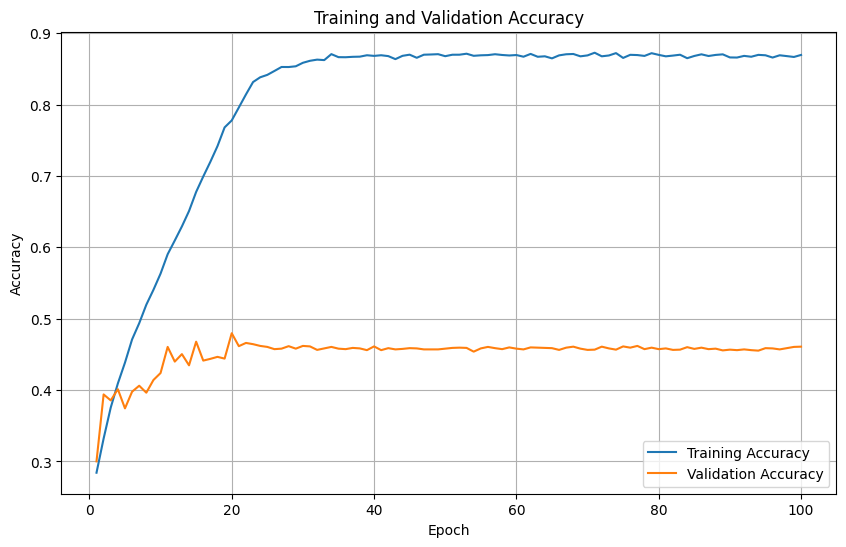

In [16]:
import matplotlib.pyplot as plt
n_epochs = num_epochs * 2
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
utils.test_model(model, test_loader)
end_time = time.time()

Test acc: 0.447


In [18]:
del model
torch.cuda.empty_cache()
gc.collect()

3471

# **CNNLSTM**

In [10]:
class TimeDistributed(nn.Module):
    def __init__(self, layer):
        super(TimeDistributed, self).__init__()
        self.layer = layer

    def forward(self, x):
        tmp = x.contiguous().view(-1, x.size(-1))
        y = self.layer(tmp)
        y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y

In [7]:
class CNNLSTM(nn.Module):
    def __init__(self,
                 num_classes=4,
                 hidden_dims=256,
                 num_layers=2,
                 dropout=0.5,
                 kernel=5,
                 stride=2,
                 padding=0,
                 pool_kernel=2,
                 time_bins=400,
                 channels=22,
                 depth=32):
        super(CNNLSTM, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,
                      out_channels=depth,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=depth,
                      out_channels=depth,
                      kernel_size=kernel * 2,
                      stride=stride,
                      padding=padding + 1),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.Dropout(dropout)
        )

        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=depth,
                      out_channels=depth,
                      kernel_size=kernel * 4,
                      stride=stride,
                      padding=padding + 3),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.Dropout(dropout)
        )

        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=depth,
                      out_channels=depth * 4,
                      kernel_size=kernel * 4,
                      stride=stride,
                      padding=padding + 5),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.Dropout(dropout)
        )

        self.lstm1 = nn.LSTM(input_size=depth * 4,
                             hidden_size=hidden_dims // 2,
                             num_layers=num_layers,
                             batch_first=True,
                             bidirectional=True)

        self.lstm2 = nn.LSTM(input_size=hidden_dims,
                             hidden_size=hidden_dims // 2,
                             num_layers=num_layers,
                             batch_first=True,
                             bidirectional=True)

        self.td = nn.Sequential(
            TimeDistributed(nn.Linear(in_features=hidden_dims,
                                      out_features=hidden_dims // 2)),
            TimeDistributed(nn.ELU()),
            TimeDistributed(nn.BatchNorm1d(hidden_dims // 2)),
            TimeDistributed(nn.Dropout(dropout)),

            TimeDistributed(nn.Linear(in_features=hidden_dims // 2,
                                      out_features=hidden_dims // 4)),
            TimeDistributed(nn.ELU()),
            TimeDistributed(nn.BatchNorm1d(hidden_dims // 4)),
            TimeDistributed(nn.Dropout(dropout)),
        )

        self.dense = nn.Linear(in_features=hidden_dims // 4,
                               out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.transpose(1, 2)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.td(x)
        x = x[:, -1, :]
        x = self.dense(x)
        return F.log_softmax(x, dim=1)




In [8]:
torchinfo.summary(CNNLSTM(), input_size=(batch_size, 22, 400))

NameError: name 'TimeDistributed' is not defined

In [ ]:
params = utils.learn_hyperparameters(X_train=X_train,
                                     y_train=y_train,
                                     X_valid=X_valid,
                                     y_valid=y_valid,
                                     model_name='CNNLSTM',
                                     num_epochs=num_epochs,
                                     trials=num_trials)

In [ ]:
model = clstm.CNNLSTM(num_classes=4,
              hidden_dims=params.get('hidden_dims'),
              dropout=params.get('dropout'),
              kernel=params.get('kernel'),
              pool_kernel=params.get('pool_kernel'),
              depth=params.get('depth'))

criterion = nn.CrossEntropyLoss()
if params.get('optimizer_name') == 'RMSprop' or params.get('optimizer_name') == 'SGD':
    optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
                                                                    lr=params.get('learning_rate'),
                                                                    weight_decay=params.get('weight_decay'),
                                                                    momentum=params.get('momentum'))
else:
    optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
                                                                    lr=params.get('learning_rate'),
                                                                    weight_decay=params.get('weight_decay'))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

torchinfo.summary(model, input_size=(params.get('batch_size'), 22, 400))

In [56]:
model = CNNLSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0008)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [57]:
train_accuracies, val_accuracies = utils.train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=num_epochs * 2,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.283, Val acc: 0.307, Val loss: 1.416
Epoch 2


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.380, Val acc: 0.415, Val loss: 1.294
Epoch 3


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.418, Val acc: 0.395, Val loss: 1.265
Epoch 4


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.445, Val acc: 0.416, Val loss: 1.244
Epoch 5


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.462, Val acc: 0.426, Val loss: 1.229
Epoch 6


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.479, Val acc: 0.421, Val loss: 1.228
Epoch 7


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.488, Val acc: 0.443, Val loss: 1.207
Epoch 8


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.494, Val acc: 0.428, Val loss: 1.224
Epoch 9


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.505, Val acc: 0.447, Val loss: 1.221
Epoch 10


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.507, Val acc: 0.449, Val loss: 1.176
Epoch 11


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.521, Val acc: 0.443, Val loss: 1.179
Epoch 12


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.527, Val acc: 0.454, Val loss: 1.198
Epoch 13


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.529, Val acc: 0.459, Val loss: 1.153
Epoch 14


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.529, Val acc: 0.466, Val loss: 1.195
Epoch 15


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.538, Val acc: 0.467, Val loss: 1.193
Epoch 16


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.540, Val acc: 0.465, Val loss: 1.183
Epoch 17


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.545, Val acc: 0.447, Val loss: 1.260
Epoch 18


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.549, Val acc: 0.475, Val loss: 1.212
Epoch 19


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.552, Val acc: 0.496, Val loss: 1.155
Epoch 20


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.560, Val acc: 0.487, Val loss: 1.128
Epoch 21


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.559, Val acc: 0.471, Val loss: 1.089
Epoch 22


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.565, Val acc: 0.460, Val loss: 1.178
Epoch 23


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.564, Val acc: 0.480, Val loss: 1.067
Epoch 24


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.571, Val acc: 0.471, Val loss: 1.114
Epoch 25


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.569, Val acc: 0.471, Val loss: 1.157
Epoch 26


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.574, Val acc: 0.483, Val loss: 1.112
Epoch 27


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.577, Val acc: 0.497, Val loss: 1.074
Epoch 28


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.576, Val acc: 0.485, Val loss: 1.201
Epoch 29


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.585, Val acc: 0.491, Val loss: 1.199
Epoch 30


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.581, Val acc: 0.479, Val loss: 1.182
Epoch 31


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.584, Val acc: 0.479, Val loss: 1.183
Epoch 32


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.588, Val acc: 0.495, Val loss: 1.078
Epoch 33


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.588, Val acc: 0.497, Val loss: 1.080
Epoch 34


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.596, Val acc: 0.488, Val loss: 1.160
Epoch 35


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.597, Val acc: 0.507, Val loss: 1.097
Epoch 36


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.605, Val acc: 0.512, Val loss: 1.091
Epoch 37


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.613, Val acc: 0.510, Val loss: 1.090
Epoch 38


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.611, Val acc: 0.508, Val loss: 1.113
Epoch 39


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.615, Val acc: 0.517, Val loss: 1.106
Epoch 40


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.617, Val acc: 0.510, Val loss: 1.109
Epoch 41


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.619, Val acc: 0.511, Val loss: 1.107
Epoch 42


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.620, Val acc: 0.514, Val loss: 1.127
Epoch 43


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.616, Val acc: 0.512, Val loss: 1.111
Epoch 44


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.621, Val acc: 0.514, Val loss: 1.108
Epoch 45


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.623, Val acc: 0.512, Val loss: 1.104
Epoch 46


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.623, Val acc: 0.514, Val loss: 1.109
Epoch 47


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.626, Val acc: 0.516, Val loss: 1.108
Epoch 48


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.624, Val acc: 0.514, Val loss: 1.105
Epoch 49


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.625, Val acc: 0.514, Val loss: 1.114
Epoch 50


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.622, Val acc: 0.517, Val loss: 1.115
Epoch 51


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.622, Val acc: 0.513, Val loss: 1.114
Epoch 52


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.630, Val acc: 0.516, Val loss: 1.111
Epoch 53


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.621, Val acc: 0.517, Val loss: 1.111
Epoch 54


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.624, Val acc: 0.517, Val loss: 1.115
Epoch 55


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.621, Val acc: 0.518, Val loss: 1.113
Epoch 56


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.623, Val acc: 0.517, Val loss: 1.117
Epoch 57


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.621, Val acc: 0.515, Val loss: 1.116
Epoch 58


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.622, Val acc: 0.517, Val loss: 1.113
Epoch 59


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.623, Val acc: 0.514, Val loss: 1.112
Epoch 60


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.625, Val acc: 0.518, Val loss: 1.112
Epoch 61


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.625, Val acc: 0.515, Val loss: 1.114
Epoch 62


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.627, Val acc: 0.519, Val loss: 1.113
Epoch 63


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.623, Val acc: 0.516, Val loss: 1.116
Epoch 64


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.623, Val acc: 0.517, Val loss: 1.109
Epoch 65


  0%|          | 0/130 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
n_epochs = num_epochs * 2
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
utils.test_model(model, test_loader)
end_time = time.time()

In [ ]:
del model
torch.cuda.empty_cache()
gc.collect()

In [ ]:
end_time = time.time()
print('time i will never get back:')
hours = (end_time - start_time) // 3600
minutes = ((end_time - start_time) % 3600) // 60
seconds = (end_time - start_time) % 60

print(f'time to train models: \
{hours} hours, \
{minutes} minutes, \
{int(seconds)} seconds')

# other

## cnn

In [9]:
class TimeDistributed(nn.Module):
    def __init__(self, layer):
        super(TimeDistributed, self).__init__()
        self.layer = layer

    def forward(self, x):
        tmp = x.contiguous().view(-1, x.size(-1))
        y = self.layer(tmp)
        y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y

In [17]:
class CNN(nn.Module):
    def __init__(self,
                 num_classes=4,
                 hidden_dims=256,
                 dropout=0.5,
                 kernel=10,
                 stride=1,
                 padding=0,
                 pool_kernel=3,
                 time_bins=400,
                 channels=22,
                 depth=25):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,
                      out_channels=depth,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.Dropout(dropout)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=depth,
                      out_channels=depth * 2,
                      kernel_size=(1, depth),
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(depth * 2),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 2,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 4),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 8,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 8),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.nd = nn.Sequential(
            TimeDistributed(nn.Linear(in_features=depth * 8, out_features=depth * 4)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth * 4)),
        )

        self.dense = nn.Linear(in_features=depth * 4,
                               out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)
        x = self.conv2(x)
        x = x.squeeze(2)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.transpose(1, 2)
        # print(x.shape)
        x = self.nd(x)        
        x = x[:, -1, :]
        x = self.dense(x)

        return F.log_softmax(x, dim=1)


In [18]:
batch_size = 256
torchinfo.summary(CNN(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 4]                   --
├─Sequential: 1-1                        [64, 25, 391]             --
│    └─Conv1d: 2-1                       [64, 25, 391]             5,525
│    └─ReLU: 2-2                         [64, 25, 391]             --
│    └─BatchNorm1d: 2-3                  [64, 25, 391]             50
│    └─Dropout: 2-4                      [64, 25, 391]             --
├─Sequential: 1-2                        [64, 50, 1, 122]          --
│    └─Conv2d: 2-5                       [64, 50, 1, 367]          31,300
│    └─ReLU: 2-6                         [64, 50, 1, 367]          --
│    └─BatchNorm2d: 2-7                  [64, 50, 1, 367]          100
│    └─MaxPool2d: 2-8                    [64, 50, 1, 122]          --
│    └─Dropout: 2-9                      [64, 50, 1, 122]          --
├─Sequential: 1-3                        [64, 100, 37]             --
│    └─

In [35]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)

In [36]:
train_accuracies, val_accuracies = utils.train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=50,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.312, Val acc: 0.357, Val loss: 1.383
Epoch 2


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.400, Val acc: 0.419, Val loss: 1.217
Epoch 3


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.462, Val acc: 0.386, Val loss: 1.286
Epoch 4


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.510, Val acc: 0.476, Val loss: 1.183
Epoch 5


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.551, Val acc: 0.509, Val loss: 1.126
Epoch 6


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.588, Val acc: 0.534, Val loss: 1.098
Epoch 7


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.612, Val acc: 0.567, Val loss: 1.020
Epoch 8


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.630, Val acc: 0.566, Val loss: 1.064
Epoch 9


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.647, Val acc: 0.590, Val loss: 1.017
Epoch 10


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.649, Val acc: 0.579, Val loss: 1.038
Epoch 11


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.664, Val acc: 0.585, Val loss: 1.032
Epoch 12


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.662, Val acc: 0.581, Val loss: 1.033
Epoch 13


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.661, Val acc: 0.613, Val loss: 1.016
Epoch 14


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.668, Val acc: 0.588, Val loss: 1.032
Epoch 15


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.682, Val acc: 0.598, Val loss: 1.095
Epoch 16


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.681, Val acc: 0.593, Val loss: 1.087
Epoch 17


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.689, Val acc: 0.632, Val loss: 0.931
Epoch 18


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.696, Val acc: 0.606, Val loss: 1.011
Epoch 19


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.702, Val acc: 0.646, Val loss: 0.870
Epoch 20


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.723, Val acc: 0.629, Val loss: 0.928
Epoch 21


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.731, Val acc: 0.652, Val loss: 0.917
Epoch 22


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.743, Val acc: 0.637, Val loss: 0.972
Epoch 23


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.759, Val acc: 0.658, Val loss: 0.892
Epoch 24


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.767, Val acc: 0.631, Val loss: 0.925
Epoch 25


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.786, Val acc: 0.633, Val loss: 0.970
Epoch 26


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.795, Val acc: 0.635, Val loss: 0.932
Epoch 27


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.810, Val acc: 0.643, Val loss: 0.911
Epoch 28


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.819, Val acc: 0.647, Val loss: 0.885
Epoch 29


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.826, Val acc: 0.673, Val loss: 0.836
Epoch 30


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.827, Val acc: 0.658, Val loss: 0.893
Epoch 31


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.832, Val acc: 0.672, Val loss: 0.866
Epoch 32


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.834, Val acc: 0.663, Val loss: 0.883
Epoch 33


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.831, Val acc: 0.651, Val loss: 0.929
Epoch 34


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.838, Val acc: 0.646, Val loss: 0.883
Epoch 35


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.833, Val acc: 0.670, Val loss: 0.859
Epoch 36


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.827, Val acc: 0.663, Val loss: 0.893
Epoch 37


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.833, Val acc: 0.659, Val loss: 0.904
Epoch 38


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.820, Val acc: 0.633, Val loss: 0.992
Epoch 39


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.821, Val acc: 0.646, Val loss: 0.919
Epoch 40


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.824, Val acc: 0.629, Val loss: 0.898
Epoch 41


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.832, Val acc: 0.643, Val loss: 0.909
Epoch 42


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.833, Val acc: 0.642, Val loss: 0.910
Epoch 43


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.837, Val acc: 0.666, Val loss: 0.856
Epoch 44


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.845, Val acc: 0.642, Val loss: 0.889
Epoch 45


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.854, Val acc: 0.642, Val loss: 0.863
Epoch 46


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.860, Val acc: 0.652, Val loss: 0.892
Epoch 47


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.865, Val acc: 0.652, Val loss: 0.881
Epoch 48


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.874, Val acc: 0.665, Val loss: 0.838
Epoch 49


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.657, Val loss: 0.845
Epoch 50


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.884, Val acc: 0.659, Val loss: 0.849


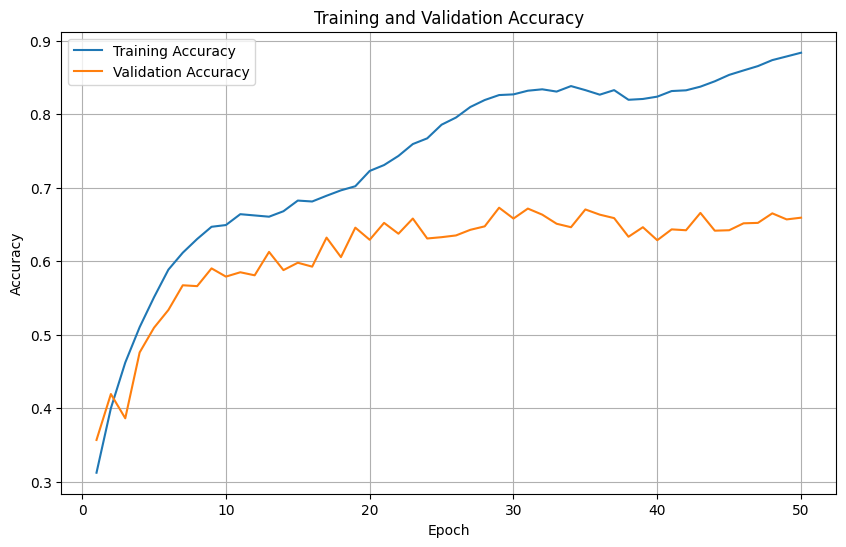

In [38]:
import matplotlib.pyplot as plt
n_epochs = 50
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
utils.test_model(model, test_loader)

Test acc: 0.621


## shallow cnn

In [40]:
class TimeDistributed(nn.Module):
    def __init__(self, layer):
        super(TimeDistributed, self).__init__()
        self.layer = layer

    def forward(self, x):
        tmp = x.contiguous().view(-1, x.size(-1))
        y = self.layer(tmp)
        y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y

In [57]:
class Shallow(nn.Module):
    def __init__(self,
                 num_classes=4,
                 hidden_dims=256,
                 dropout=0.5,
                 kernel=25,
                 stride=1,
                 padding=0,
                 pool_kernel=50,
                 time_bins=400,
                 channels=22,
                 depth=25):
        super(Shallow, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,
                      out_channels=depth,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.Dropout(dropout)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=depth,
                      out_channels=depth * 8,
                      kernel_size=(1, depth),
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm2d(depth * 8),
            nn.AvgPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout),
            nn.Tanh()
        )

        self.nd = nn.Sequential(
            nn.Linear(in_features=depth * 8, out_features=depth * 4),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.Dropout(dropout),
            nn.Linear(in_features=depth * 4, out_features=depth * 2),
            nn.ReLU(),
        )

        self.dense = nn.Linear(in_features=depth * 2,
                               out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)
        x = self.conv2(x)
        x = x.squeeze(2)
        x = x.transpose(1, 2)
        x = x[:, -1, :]
        x = self.nd(x)
        x = self.dense(x)

        return F.log_softmax(x, dim=1)

In [58]:
batch_size = 128
torchinfo.summary(Shallow(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
Shallow                                  [128, 4]                  --
├─Sequential: 1-1                        [128, 25, 376]            --
│    └─Conv1d: 2-1                       [128, 25, 376]            13,775
│    └─ReLU: 2-2                         [128, 25, 376]            --
│    └─BatchNorm1d: 2-3                  [128, 25, 376]            50
│    └─Dropout: 2-4                      [128, 25, 376]            --
├─Sequential: 1-2                        [128, 200, 1, 7]          --
│    └─Conv2d: 2-5                       [128, 200, 1, 352]        125,200
│    └─ELU: 2-6                          [128, 200, 1, 352]        --
│    └─BatchNorm2d: 2-7                  [128, 200, 1, 352]        400
│    └─AvgPool2d: 2-8                    [128, 200, 1, 7]          --
│    └─Dropout: 2-9                      [128, 200, 1, 7]          --
│    └─Tanh: 2-10                        [128, 200, 1, 7]          --
├─Seq

In [59]:
model = Shallow().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0005, momentum=0.95)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)

In [60]:
train_accuracies, val_accuracies = utils.train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=50,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.273, Val acc: 0.248, Val loss: 1.382
Epoch 2


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.293, Val acc: 0.240, Val loss: 1.390
Epoch 3


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.301, Val acc: 0.288, Val loss: 1.380
Epoch 4


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.307, Val acc: 0.266, Val loss: 1.372
Epoch 5


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.321, Val acc: 0.266, Val loss: 1.379
Epoch 6


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.332, Val acc: 0.279, Val loss: 1.373
Epoch 7


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.334, Val acc: 0.285, Val loss: 1.369
Epoch 8


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.340, Val acc: 0.277, Val loss: 1.370
Epoch 9


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.345, Val acc: 0.274, Val loss: 1.362
Epoch 10


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.355, Val acc: 0.277, Val loss: 1.361
Epoch 11


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.352, Val acc: 0.277, Val loss: 1.360
Epoch 12


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.351, Val acc: 0.274, Val loss: 1.362
Epoch 13


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.353, Val acc: 0.269, Val loss: 1.356
Epoch 14


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.356, Val acc: 0.267, Val loss: 1.361
Epoch 15


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.351, Val acc: 0.256, Val loss: 1.368
Epoch 16


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.359, Val acc: 0.273, Val loss: 1.371
Epoch 17


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.353, Val acc: 0.251, Val loss: 1.370
Epoch 18


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.364, Val acc: 0.248, Val loss: 1.403
Epoch 19


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.368, Val acc: 0.259, Val loss: 1.380
Epoch 20


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.366, Val acc: 0.265, Val loss: 1.381
Epoch 21


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.376, Val acc: 0.285, Val loss: 1.392
Epoch 22


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.383, Val acc: 0.242, Val loss: 1.436
Epoch 23


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.394, Val acc: 0.246, Val loss: 1.456
Epoch 24


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.406, Val acc: 0.234, Val loss: 1.438
Epoch 25


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.405, Val acc: 0.275, Val loss: 1.400
Epoch 26


  0%|          | 0/77 [00:00<?, ?it/s]

Train acc: 0.412, Val acc: 0.267, Val loss: 1.408
Epoch 27


  0%|          | 0/77 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
n_epochs = 50
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
utils.test_model(model, test_loader)
end_time = time.time()

## cnn lstm

In [6]:
class TimeDistributed(nn.Module):
    def __init__(self, layer):
        super(TimeDistributed, self).__init__()
        self.layer = layer

    def forward(self, x):
        tmp = x.contiguous().view(-1, x.size(-1))
        y = self.layer(tmp)
        y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y

In [70]:
class CNNLSTM(nn.Module):
    def __init__(self,
                 num_classes=4,
                 hidden_dims=256,
                 num_layers=2,
                 dropout=0.5,
                 kernel=3,
                 stride=2,
                 padding=0,
                 pool_kernel=2,
                 time_bins=400,
                 channels=22,
                 depth=25):
        super(CNNLSTM, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,
                      out_channels=depth,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=depth,
                      out_channels=depth * 2,
                      kernel_size=(1, depth),
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm2d(depth * 2),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 2,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 3),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 5),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 8,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm1d(depth * 8),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.linear = nn.Sequential(
            nn.Linear(in_features=depth * 8,
                      out_features=depth * 8),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 8),
            nn.MaxPool1d(kernel_size=pool_kernel),
        )

        self.lstm1 = nn.LSTM(input_size=depth * 4,
                             hidden_size=depth * 4,
                             num_layers=num_layers,
                             batch_first=True,
                             bidirectional=True)

        self.lstm2 = nn.LSTM(input_size=depth * 8,
                             hidden_size=depth * 4,
                             num_layers=num_layers,
                             batch_first=True,
                             bidirectional=True)

        self.td = nn.Sequential(
            TimeDistributed(nn.Linear(in_features=depth * 8, out_features=depth * 4)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth * 4)),
            # TimeDistributed(nn.Dropout(dropout)),
            # TimeDistributed(nn.Linear(in_features=depth * 4, out_features=depth * 2)),
            # TimeDistributed(nn.ReLU()),
            # TimeDistributed(nn.BatchNorm1d(depth * 2)),
            # TimeDistributed(nn.Dropout(dropout)),
        )

        self.dense = nn.Linear(in_features=depth * 4, out_features=num_classes)

        self.nd = nn.Sequential(
            nn.Linear(in_features=depth * 8, out_features=depth * 4),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.Dropout(dropout),
            # nn.Linear(in_features=depth * 4, out_features=depth * 2),
            # nn.ReLU(),
            # nn.BatchNorm1d(depth * 2),
            # nn.Dropout(dropout),
            # nn.Linear(in_features=depth * 2, out_features=depth),
            # nn.ReLU(),
            # nn.BatchNorm1d(depth),
            # nn.Dropout(dropout),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)
        x = self.conv2(x)
        x = x.squeeze(2)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.transpose(1, 2)
        x = x[:, -1, :]
        x = self.linear(x)
        x, _ = self.lstm1(x)
        #x, _ = self.lstm2(x)
        #x = self.td(x)
        x = self.nd(x)
        x = self.dense(x)
        return F.log_softmax(x, dim=1)

In [74]:
batch_size = 128
torchinfo.summary(CNNLSTM(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CNNLSTM                                  [128, 4]                  503,500
├─Sequential: 1-1                        [128, 25, 199]            --
│    └─Conv1d: 2-1                       [128, 25, 199]            1,675
│    └─ReLU: 2-2                         [128, 25, 199]            --
├─Sequential: 1-2                        [128, 50, 1, 44]          --
│    └─Conv2d: 2-3                       [128, 50, 1, 88]          31,300
│    └─ELU: 2-4                          [128, 50, 1, 88]          --
│    └─BatchNorm2d: 2-5                  [128, 50, 1, 88]          100
│    └─MaxPool2d: 2-6                    [128, 50, 1, 44]          --
│    └─Dropout: 2-7                      [128, 50, 1, 44]          --
├─Sequential: 1-3                        [128, 100, 24]            --
│    └─Conv1d: 2-8                       [128, 100, 24]            15,100
│    └─ELU: 2-9                          [128, 100, 24]            -

In [75]:
model = CNNLSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=0.001, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)

In [76]:
train_accuracies, val_accuracies = utils.train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=100,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/92 [00:00<?, ?it/s]

Train acc: 0.250, Val acc: 0.207, Val loss: 2.474
Epoch 2


  0%|          | 0/92 [00:00<?, ?it/s]

Train acc: 0.280, Val acc: 0.232, Val loss: 4.173
Epoch 3


  0%|          | 0/92 [00:00<?, ?it/s]

Train acc: 0.338, Val acc: 0.330, Val loss: 1.527
Epoch 4


  0%|          | 0/92 [00:00<?, ?it/s]

Train acc: 0.410, Val acc: 0.314, Val loss: 1.470
Epoch 5


  0%|          | 0/92 [00:00<?, ?it/s]

Train acc: 0.458, Val acc: 0.324, Val loss: 1.420
Epoch 6


  0%|          | 0/92 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
n_epochs = 100
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
utils.test_model(model, test_loader)
end_time = time.time()

## gru

In [41]:
class TimeDistributed(nn.Module):
    def __init__(self, layer):
        super(TimeDistributed, self).__init__()
        self.layer = layer

    def forward(self, x):
        tmp = x.contiguous().view(-1, x.size(-1))
        y = self.layer(tmp)
        y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y

In [109]:
class GRU(nn.Module):
    def __init__(self,
                 num_classes=4,
                 hidden_dims=128,
                 num_layers=2,
                 dropout=0.5,
                 kernel=7,
                 stride=1,
                 padding=0,
                 pool_kernel=3,
                 time_bins=400,
                 channels=22,
                 depth=64):
        super(GRU, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,
                      out_channels=depth,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.Dropout(dropout)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=depth,
                      out_channels=depth * 2,
                      kernel_size=(1, depth),
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm2d(depth * 2),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 2,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 1),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 3),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 8,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 5),
            nn.ELU(),
            nn.BatchNorm1d(depth * 8),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.nd = nn.Sequential(
            nn.Linear(in_features=depth * 8, out_features=depth * 4),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.Dropout(dropout),
        )

        self.gru = nn.GRU(input_size=depth * 4,
                           hidden_size=depth * 4,
                           num_layers=num_layers,
                           bias=True,
                           batch_first=True,
                           bidirectional=True)

        self.td = nn.Sequential(
            TimeDistributed(nn.Linear(in_features=depth * 8, out_features=depth * 4)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth * 4)),
            TimeDistributed(nn.Dropout(dropout)),
            TimeDistributed(nn.Linear(in_features=depth * 4, out_features=depth * 2)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth * 2)),
            TimeDistributed(nn.Dropout(dropout)),
            TimeDistributed(nn.Linear(in_features=depth * 2, out_features=depth)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth)),
            TimeDistributed(nn.Dropout(dropout)),
        )
        self.dense = nn.Linear(in_features=depth * 8, out_features=num_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)
        x = self.conv2(x)
        x = x.squeeze(2)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.transpose(1, 2)
        x = x[:, -1, :]
        x = self.nd(x)
        x, _ = self.gru(x)
        #x = self.td(x)
        x = self.dense(x)
        return F.log_softmax(x, dim=1)

In [110]:
batch_size = 64
torchinfo.summary(GRU(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
GRU                                      [64, 4]                   173,376
├─Sequential: 1-1                        [64, 64, 394]             --
│    └─Conv1d: 2-1                       [64, 64, 394]             9,920
│    └─ReLU: 2-2                         [64, 64, 394]             --
│    └─BatchNorm1d: 2-3                  [64, 64, 394]             128
│    └─Dropout: 2-4                      [64, 64, 394]             --
├─Sequential: 1-2                        [64, 128, 1, 110]         --
│    └─Conv2d: 2-5                       [64, 128, 1, 331]         524,416
│    └─ELU: 2-6                          [64, 128, 1, 331]         --
│    └─BatchNorm2d: 2-7                  [64, 128, 1, 331]         256
│    └─MaxPool2d: 2-8                    [64, 128, 1, 110]         --
│    └─Dropout: 2-9                      [64, 128, 1, 110]         --
├─Sequential: 1-3                        [64, 256, 35]             --


In [113]:
model = GRU().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0008)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)

In [ ]:
train_accuracies, val_accuracies = utils.train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=50,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/92 [00:00<?, ?it/s]

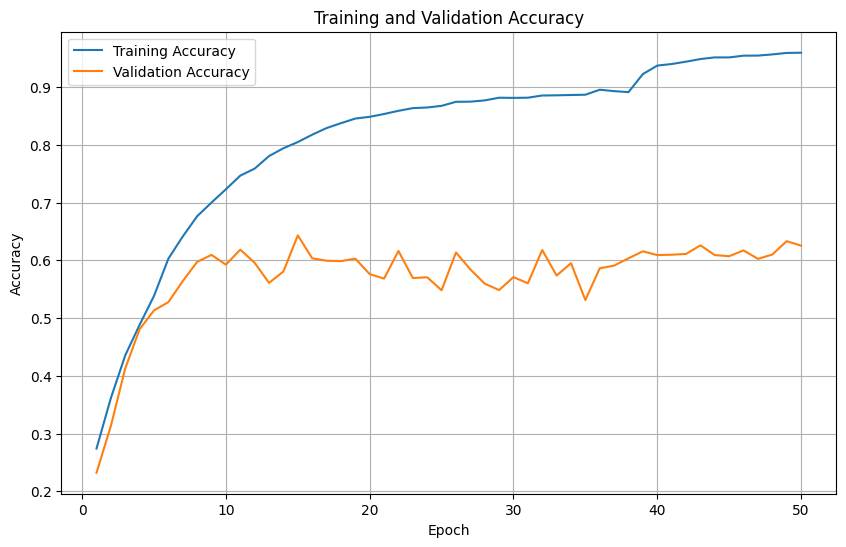

In [46]:
import matplotlib.pyplot as plt
n_epochs = 50
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
utils.test_model(model, test_loader)
end_time = time.time()

Test acc: 0.652


In [48]:
print('time i will never get back:')
hours = (end_time - start_time) // 3600
minutes = ((end_time - start_time) % 3600) // 60
seconds = (end_time - start_time) % 60

print(f'time to train models: \
{hours} hours, \
{minutes} minutes, \
{int(seconds)} seconds')

time i will never get back:
time to train models: 0.0 hours, 41.0 minutes, 57 seconds


In [16]:
import torch
import torch.nn as nn

class LSTM_LSTM(nn.Module):
    def __init__(self,
                 input_size = 22,
                 hidden_size = 64,
                 num_layers = 2,
                 output_size = 54,
                 num_classes = 4):
        super(LSTM_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # First LSTM layer
        self.lstm1 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True,
                             bidirectional=True)

        # Second LSTM layer
        self.lstm2 = nn.LSTM(hidden_size * 2,
                             hidden_size,
                             num_layers,
                             batch_first=True,
                             bidirectional=True)


        # Output layer
        self.linear = nn.Linear(hidden_size * 2, output_size)
        self.fc = nn.Sequential(
            nn.Linear(output_size, output_size-10),
            nn.BatchNorm1d(num_features=output_size-10, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Linear(output_size-10, num_classes)
        )

    def forward(self, x):
        x = x.transpose(1, 2)

        # Forward pass through LSTM1
        out, _ = self.lstm1(x)

        # Forward pass through LSTM2
        out, _ = self.lstm2(out)

        # fc layer
        out = self.linear(out[:, -1, :])
        return out


In [17]:
batch_size = 64
torchinfo.summary(LSTM_LSTM(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM_LSTM                                [64, 54]                  2,688
├─LSTM: 1-1                              [64, 400, 128]            144,384
├─LSTM: 1-2                              [64, 400, 128]            198,656
├─Linear: 1-3                            [64, 54]                  6,966
Total params: 352,694
Trainable params: 352,694
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 8.78
Input size (MB): 2.25
Forward/backward pass size (MB): 52.46
Params size (MB): 1.40
Estimated Total Size (MB): 56.11

In [18]:
model = LSTM_LSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0008)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
train_accuracies, val_accuracies = utils.train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=50,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/138 [00:00<?, ?it/s]

Train acc: 0.248, Val acc: 0.224, Val loss: 1.398
Epoch 2


  0%|          | 0/138 [00:00<?, ?it/s]

Train acc: 0.249, Val acc: 0.245, Val loss: 1.385
Epoch 3


  0%|          | 0/138 [00:00<?, ?it/s]

Train acc: 0.253, Val acc: 0.243, Val loss: 1.386
Epoch 4


  0%|          | 0/138 [00:00<?, ?it/s]

Train acc: 0.254, Val acc: 0.244, Val loss: 1.384
Epoch 5


  0%|          | 0/138 [00:00<?, ?it/s]

Train acc: 0.252, Val acc: 0.244, Val loss: 1.401
Epoch 6


  0%|          | 0/138 [00:00<?, ?it/s]

Train acc: 0.254, Val acc: 0.224, Val loss: 1.401
Epoch 7


  0%|          | 0/138 [00:00<?, ?it/s]

Train acc: 0.249, Val acc: 0.287, Val loss: 1.394
Epoch 8


  0%|          | 0/138 [00:00<?, ?it/s]

Train acc: 0.253, Val acc: 0.287, Val loss: 1.387
Epoch 9


  0%|          | 0/138 [00:00<?, ?it/s]

Train acc: 0.251, Val acc: 0.245, Val loss: 1.387
Epoch 10


  0%|          | 0/138 [00:00<?, ?it/s]

KeyboardInterrupt: 